In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn.functional as F
import torch
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt

from src.data.constants import LABEL_COLS_ORDERED, EXPERT_CONSENSUS_TO_LABEL_COL
from src.utils.utils import shiftedColorMap

In [3]:
bad_eeg_id_sub_ids = []
bad_eeg_ids = []

# Split 0

In [4]:
split_index = 0
embeddings = np.load(f'/workspace/hms/labels/predict_val/embeddings_{split_index}.npy')
logits = torch.from_numpy(np.load(f'/workspace/hms/labels/predict_val/logits_{split_index}.npy'))
df = pd.read_csv(f'/workspace/hms/labels/predict_val/meta_{split_index}.csv')

In [5]:
target = torch.from_numpy(df[LABEL_COLS_ORDERED].values)
log_preds = F.log_softmax(logits, dim=1)
df['kl'] = F.kl_div(
    log_preds, 
    target,
    log_target=False,
    reduction='none'
).sum(1).detach().numpy()

In [6]:
df['kl'].mean()

0.3239313806762359

In [7]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()


0.242927500903304

<Axes: >

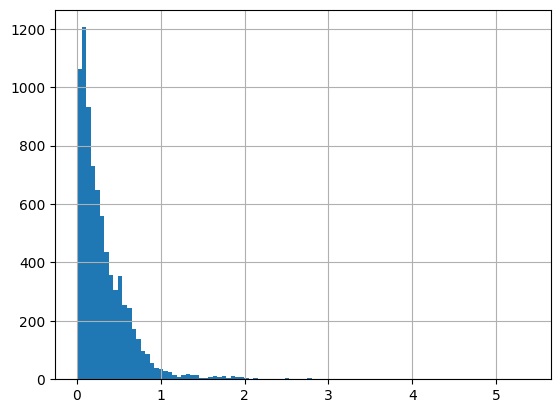

In [8]:
df['kl'].hist(bins=100)

In [9]:
reducer = umap.UMAP()
embeddings_transformed = reducer.fit_transform(embeddings)
embeddings_transformed.shape

(7968, 2)

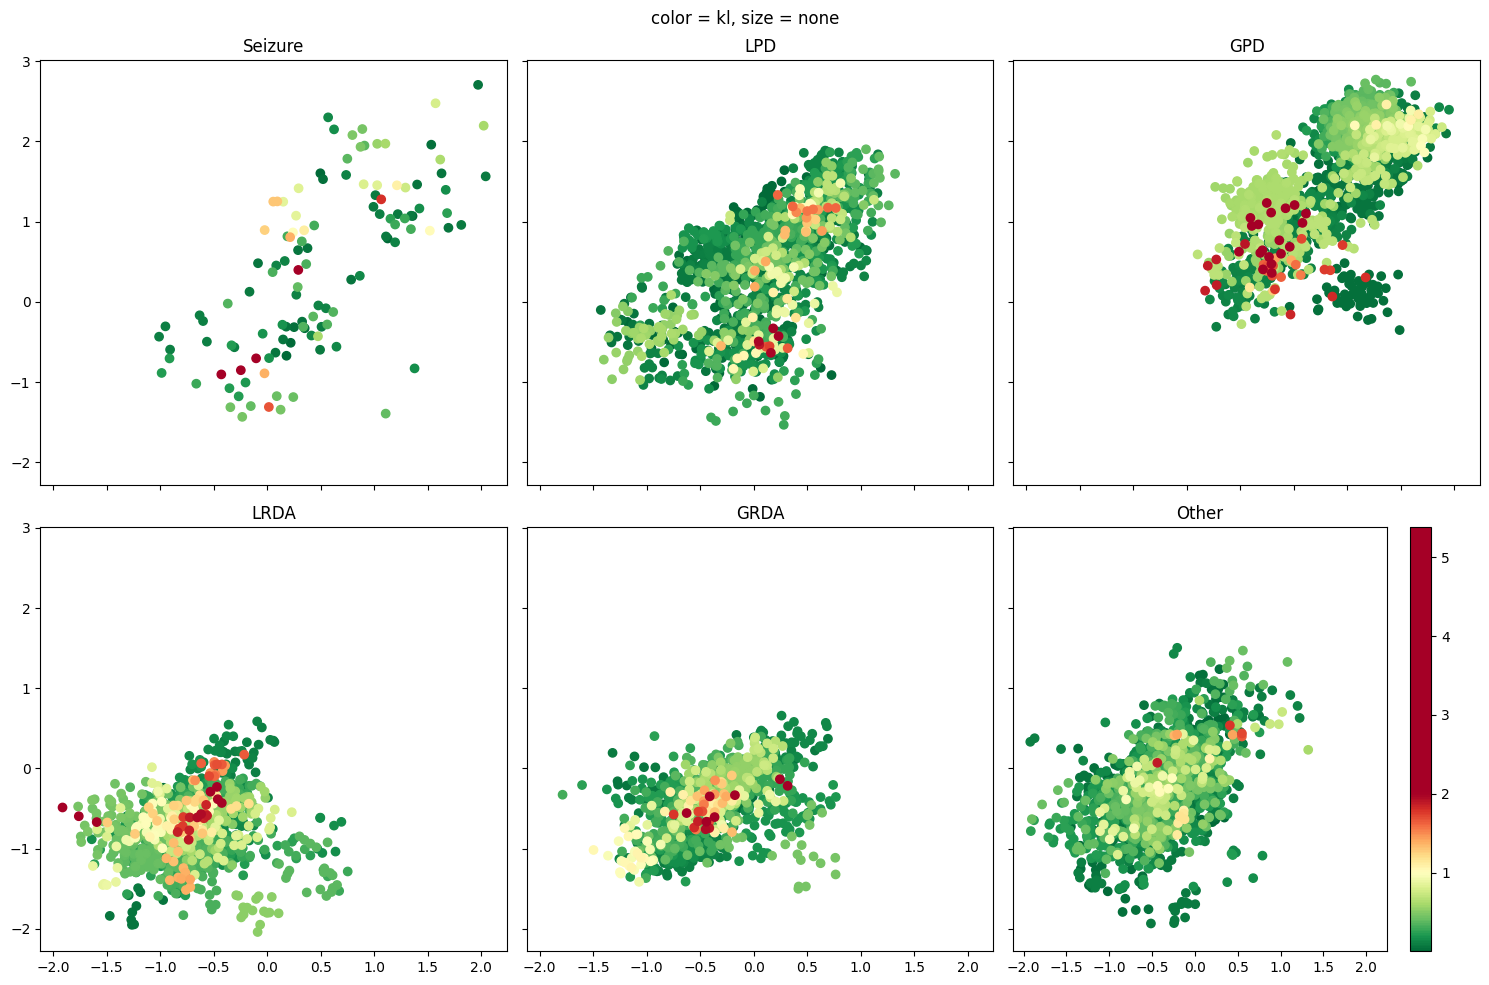

In [10]:
min_ = df['kl'].min()
max_ = df['kl'].max()
cmap = shiftedColorMap(plt.get_cmap('RdYlGn_r'), start=min_, midpoint=1.0, stop=max_, name='shifted')

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_{split_index}.png')

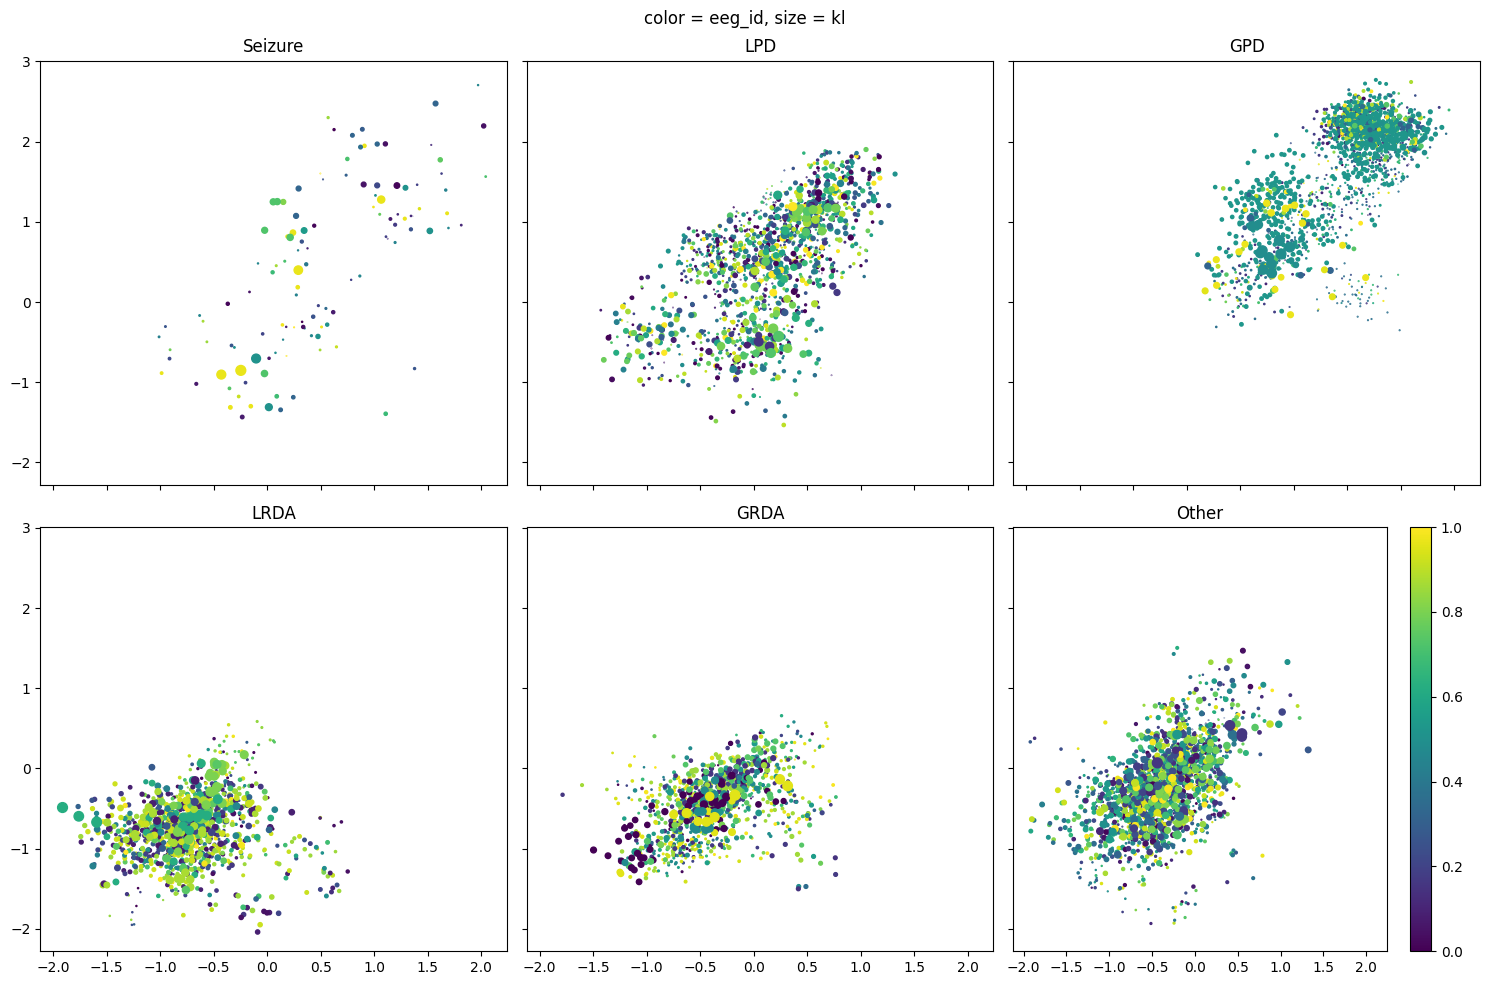

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = eeg_id, size = kl')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    # zero = 1.0
    # scale = 2 * (df_sub['kl'].max() - zero)
    # s = (
    #     df_sub['kl'] - 
    #     zero
    # ) / scale + 0.5
    s = (df_sub['kl'] - df_sub['kl'].min()) / (df_sub['kl'].max() - df_sub['kl'].min()) * 50
    # color = (df_sub['patient_id'] - df_sub['patient_id'].min()) / (df_sub['patient_id'].max() - df_sub['patient_id'].min())
    color = (df_sub['eeg_id'] - df_sub['eeg_id'].min()) / (df_sub['eeg_id'].max() - df_sub['eeg_id'].min())
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        s=s,
        c=color,
        vmin=0.0,
        vmax=1.0,
        label=ec,
        cmap='viridis'
    )
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_eeg_id_size_kl_{split_index}.png')

In [12]:
df[df['kl'] > 2.0]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
52    3120659896           0                       0.0        51264408   
1037  3395696113          10                      56.0       394227767   
2372  4087242707           6                      32.0       666908200   
2373  4087242707           7                      36.0       666908200   
2374  4087242707           8                      46.0       666908200   
2926  2713014975           0                       0.0       780890284   
2927  2713014975           1                       2.0       780890284   
2928  2713014975           2                       4.0       780890284   
3512  3475982496           4                       8.0       982293474   
3513  3475982496           5                      12.0       982293474   
3886  2096583018           0                       0.0      1089535744   
3887  2096583018           1                       2.0      1089535744   
3888  2096583018           2                       4.0      1089535744   
3889  2096583018           3                       8.0      1089535744   
3890  2096583018           4                      12.0      1089535744   
3891  2096583018           5                      14.0      1089535744   
3892  2096583018           6                      16.0      1089535744   
3893  2096583018           7                      22.0      1089535744   
3894  2096583018           8                      26.0      1089535744   
3895  2096583018           9                      28.0      1089535744   
3896  2096583018          10                      30.0      1089535744   
5589  4134620961           2                       4.0      1433063610   
5591  4134620961           4                      10.0      1433063610   
5598  4134620961          11                      28.0      1433063610   
5599  4134620961          12                      30.0      1433063610   
5600  4134620961          13                      32.0      1433063610   
5601  4134620961          14                      34.0      1433063610   
6104  2328924181           0                       0.0      1603231808   
6521  4084957171           6                      66.0      1772205786   
6522  4084957171           7                      72.0      1772205786   
6523  4084957171           8                      74.0      1772205786   
6524  4084957171           9                      76.0      1772205786   
6525  4084957171          10                      82.0      1772205786   
6526  4084957171          11                      84.0      1772205786   
6527  4084957171          12                      86.0      1772205786   
7763  1386986988           0                       0.0      2059933678   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
52                     8                             528.0  2948724133   
1037                  10                              56.0  1755078441   
2372                   8                             300.0   913623000   
2373                   9                             304.0  2721629739   
2374                  10                             314.0  3372673167   
2926                   0                               0.0  3734439265   
2927                   1                               2.0  1079200319   
2928                   2                               4.0  3215003288   
3512                   4                               8.0   961582983   
3513                   5                              12.0  1220978783   
3886                   0                               0.0  2319223138   
3887                   1                               2.0  2787804613   
3888                   2                               4.0  2879407656   
3889                   3                               8.0  2999719209   
3890                   4                              12.0  3335891423   
3891                   5                              14.0   780440256   
3892         

<Axes: >

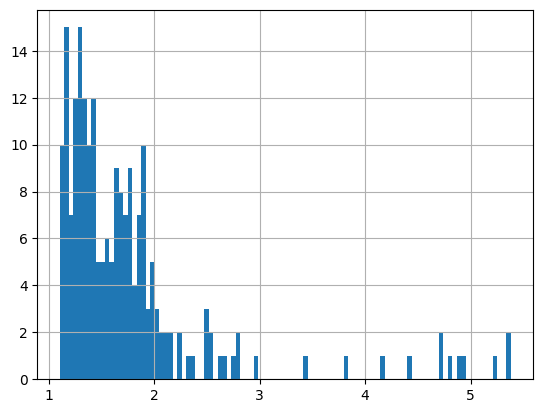

In [13]:
df[df['kl'] > 1.1]['kl'].hist(bins=100)

<Axes: >

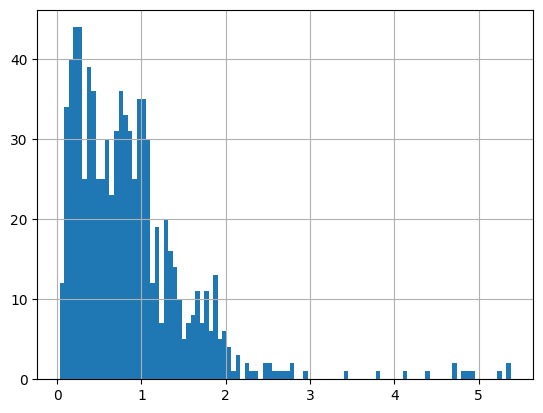

In [14]:
df[df['eeg_id'].isin(df[df['kl'] > 1.0]['eeg_id'].unique())]['kl'].hist(bins=100)

In [15]:
for ec in EXPERT_CONSENSUS_TO_LABEL_COL.keys():
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=False)
    with pd.option_context('display.max_rows', None):
        print(f'{ec}')
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id', 'eeg_sub_id', 'kl']])
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id']].value_counts())

Seizure
          eeg_id  eeg_sub_id        kl
2374  4087242707           8  3.433991
2372  4087242707           6  2.798468
6104  2328924181           0  2.750393
2373  4087242707           7  2.527516
2371  4087242707           5  1.807549
6109  2328924181           5  1.677569
6714  3161513637           3  1.375893
6715  3161513637           4  1.374448
6711  3161513637           0  1.304823
6713  3161513637           2  1.297593
6712  3161513637           1  1.251486
6228  2468334985           0  1.119063
3476   432408629           0  1.087958
6105  2328924181           1  1.021753
2370  4087242707           4  1.014503
eeg_id    
3161513637    5
4087242707    5
2328924181    3
432408629     1
2468334985    1
Name: count, dtype: int64
LPD
          eeg_id  eeg_sub_id        kl
52    3120659896           0  2.497132
1037  3395696113          10  2.048371
53    3120659896           1  1.971450
1887   660412648           0  1.966803
1042  3395696113          15  1.898099
1888   660412

In [16]:
bad_eeg_ids.extend(
    [
        # Seizure
        4087242707,
        2328924181,
        3161513637,
        # LPD
        3120659896,
        3395696113,
        660412648,
        # GPD
        2096583018,
        4134620961,
        1386986988,
        4073859883,
        2131102397,
        3149658468,
        # LRDA
        2713014975,
        3475982496,
        3760885021,
        3216469722,
        # GRDA
        4084957171,
        9240926,  #?
        2055552797,
        # Other
        701025595,
        3468817078,
        2313862496,
        1591129178
    ]
)

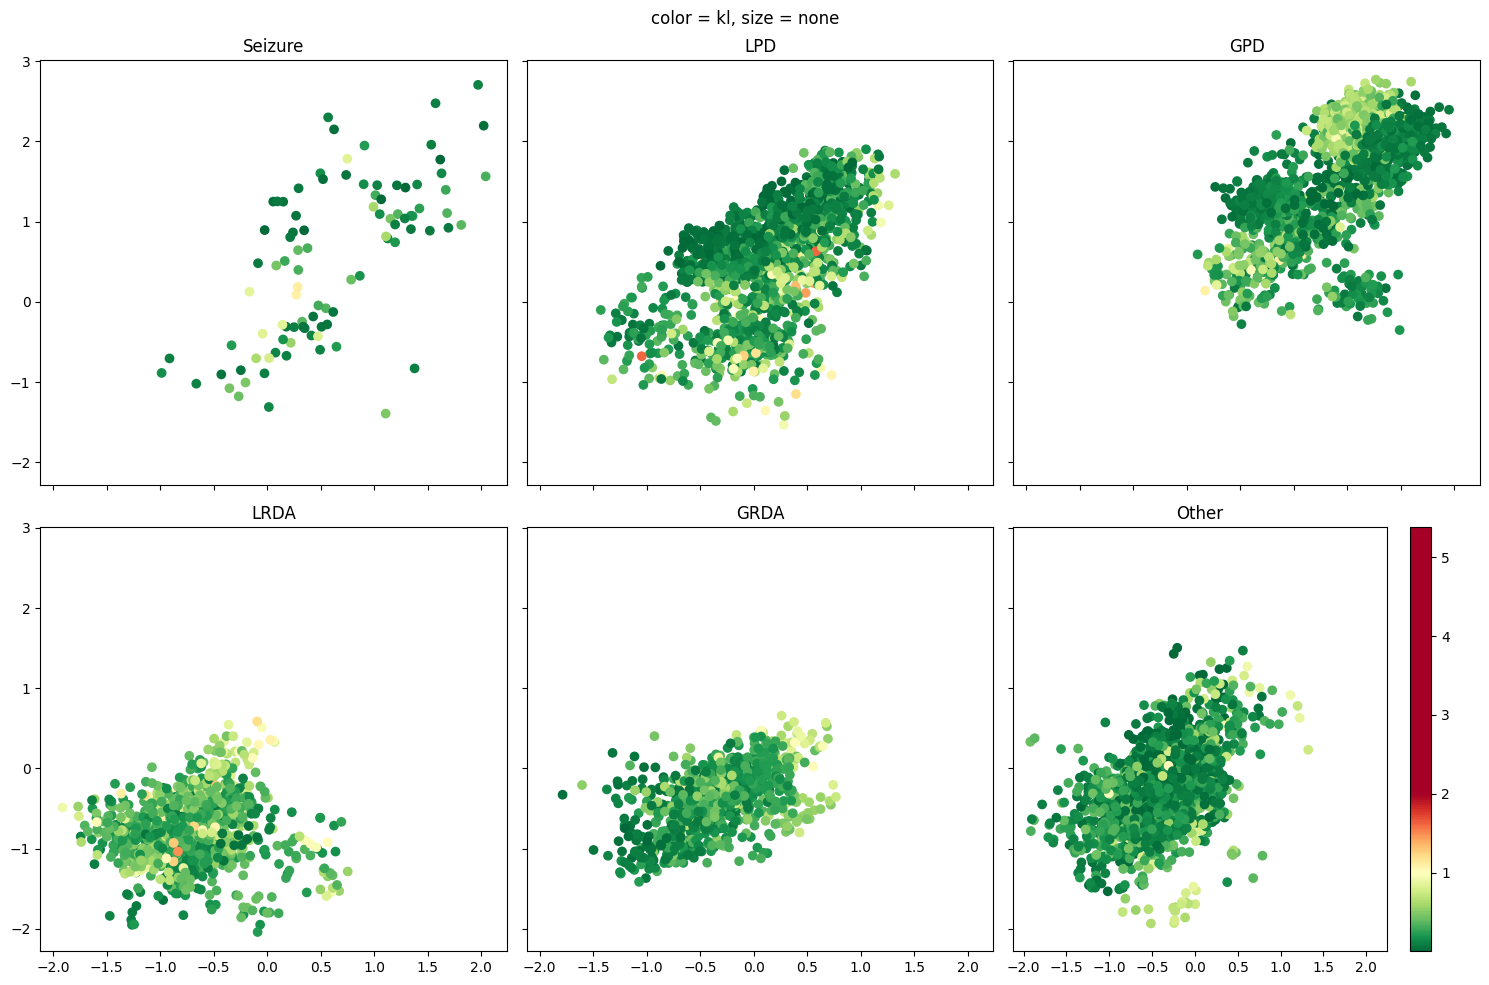

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = ((df['expert_consensus'] == ec).values) & (~df['eeg_id'].isin(bad_eeg_ids))
    df_sub = df[mask]
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_after_{split_index}.png')

In [18]:
df['eeg_id'].isin(bad_eeg_ids).sum()

423

In [19]:
df_sub = df[df['kl'] > 1.0]
bads_precise = df_sub[df_sub['eeg_id'].isin(bad_eeg_ids)][['eeg_id', 'eeg_sub_id']].values.tolist()
bad_eeg_id_sub_ids.extend(bads_precise)
len(bads_precise)

214

# Split 1

In [20]:
split_index = 1
embeddings = np.load(f'/workspace/hms/labels/predict_val/embeddings_{split_index}.npy')
logits = torch.from_numpy(np.load(f'/workspace/hms/labels/predict_val/logits_{split_index}.npy'))
df = pd.read_csv(f'/workspace/hms/labels/predict_val/meta_{split_index}.csv')

In [21]:
target = torch.from_numpy(df[LABEL_COLS_ORDERED].values)
log_preds = F.log_softmax(logits, dim=1)
df['kl'] = F.kl_div(
    log_preds, 
    target,
    log_target=False,
    reduction='none'
).sum(1).detach().numpy()

In [22]:
df['kl'].mean()

0.24932216985680755

In [23]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()


0.22180566703495563

<Axes: >

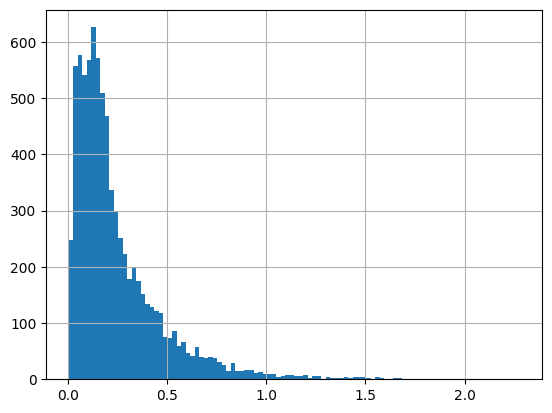

In [24]:
df['kl'].hist(bins=100)

In [25]:
reducer = umap.UMAP()
embeddings_transformed = reducer.fit_transform(embeddings)
embeddings_transformed.shape

(7968, 2)

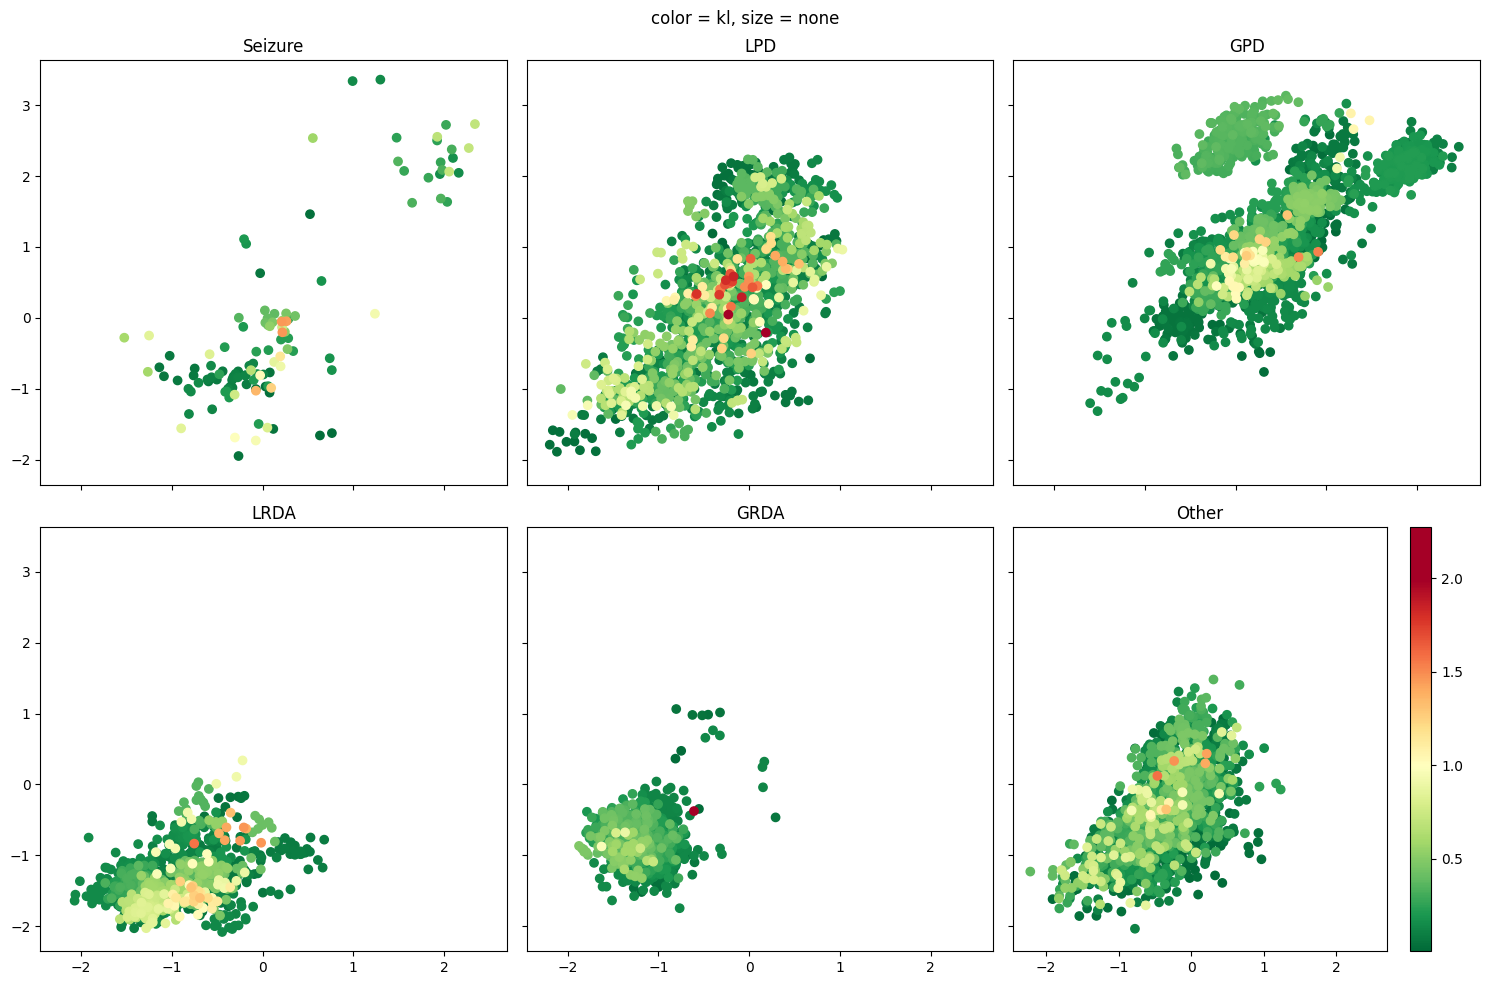

In [26]:
min_ = df['kl'].min()
max_ = df['kl'].max()
cmap = shiftedColorMap(plt.get_cmap('RdYlGn_r'), start=min_, midpoint=1.0, stop=max_, name='shifted')

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_{split_index}.png')

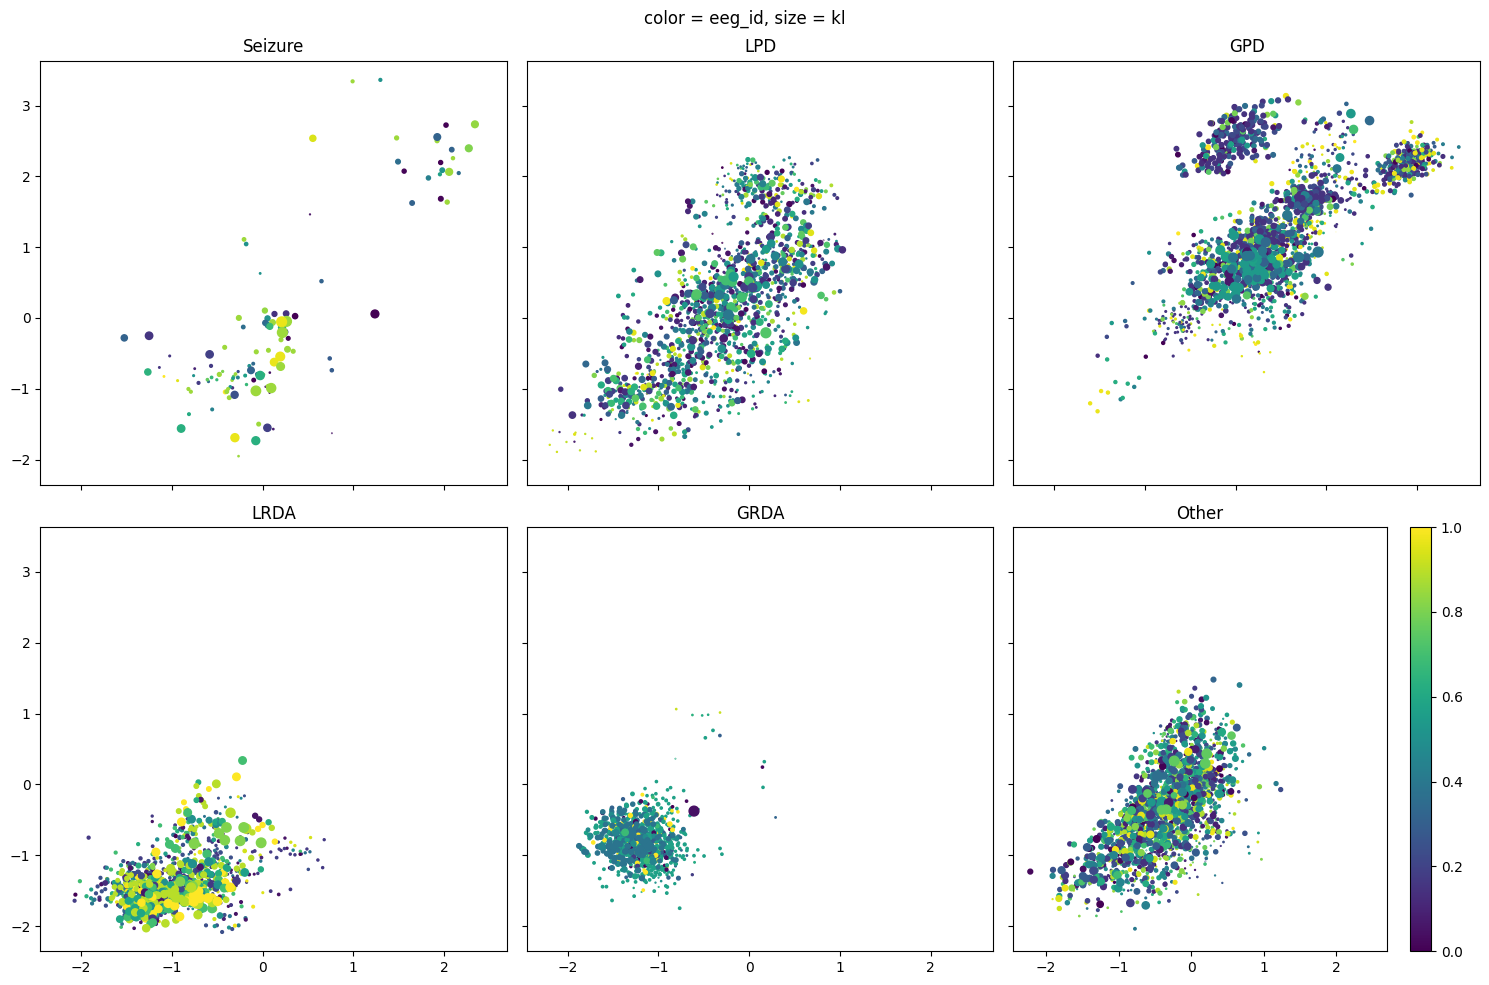

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = eeg_id, size = kl')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    # zero = 1.0
    # scale = 2 * (df_sub['kl'].max() - zero)
    # s = (
    #     df_sub['kl'] - 
    #     zero
    # ) / scale + 0.5
    s = (df_sub['kl'] - df_sub['kl'].min()) / (df_sub['kl'].max() - df_sub['kl'].min()) * 50
    # color = (df_sub['patient_id'] - df_sub['patient_id'].min()) / (df_sub['patient_id'].max() - df_sub['patient_id'].min())
    color = (df_sub['eeg_id'] - df_sub['eeg_id'].min()) / (df_sub['eeg_id'].max() - df_sub['eeg_id'].min())
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        s=s,
        c=color,
        vmin=0.0,
        vmax=1.0,
        label=ec,
        cmap='viridis'
    )
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_eeg_id_size_kl_{split_index}.png')

<Axes: >

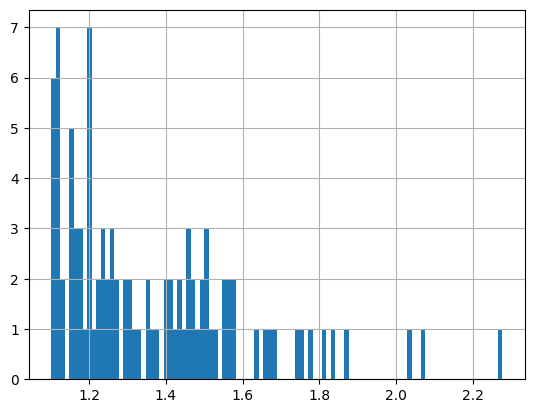

In [28]:
df[df['kl'] > 1.1]['kl'].hist(bins=100)

<Axes: >

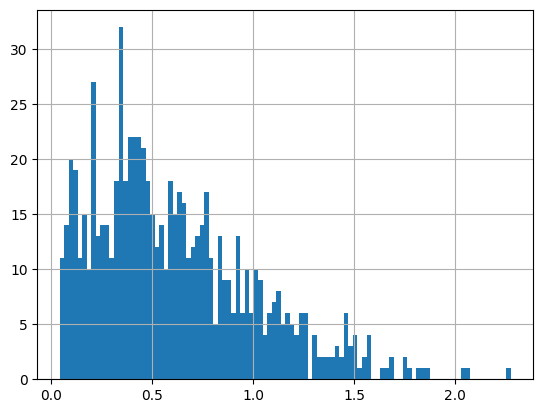

In [29]:
df[df['eeg_id'].isin(df[df['kl'] > 1.0]['eeg_id'].unique())]['kl'].hist(bins=100)

In [30]:
for ec in EXPERT_CONSENSUS_TO_LABEL_COL.keys():
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=False)
    with pd.option_context('display.max_rows', None):
        print(f'{ec}')
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id', 'eeg_sub_id', 'kl']])
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id']].value_counts())

Seizure
          eeg_id  eeg_sub_id        kl
1641  3500954630           1  1.466230
7788  3960652136           0  1.456219
1640  3500954630           0  1.438411
1642  3500954630           2  1.359110
1643  3500954630           3  1.248984
7791  3960652136           3  1.154907
557   2598460211           0  1.024839
eeg_id    
3500954630    4
3960652136    2
2598460211    1
Name: count, dtype: int64
LPD
          eeg_id  eeg_sub_id        kl
153   3125082527          12  2.275663
489   1726717743          11  2.073506
2838  2992127004           2  1.873757
5580  2368162206           4  1.834277
2837  2992127004           1  1.809076
152   3125082527          11  1.781655
487   1726717743           9  1.755484
2836  2992127004           0  1.742344
488   1726717743          10  1.681424
2839  2992127004           3  1.673588
1862   981282155           3  1.659057
490   1726717743          12  1.640329
1861   981282155           2  1.580148
2842  2992127004           6  1.566871
5576  

In [31]:
bad_eeg_ids.extend(
    [
        # Seizure
        3500954630,
        3960652136,
        # LPD
        3125082527,
        1726717743,
        2992127004,
        2368162206,
        981282155,
        2180165624, # ?
        759620270,  # ?
        # GPD
        1735972851,
        # LRDA
        3450996114,
        # GRDA
        235218950,
        # Other
        1542745222,
        3232757274,
    ]
)

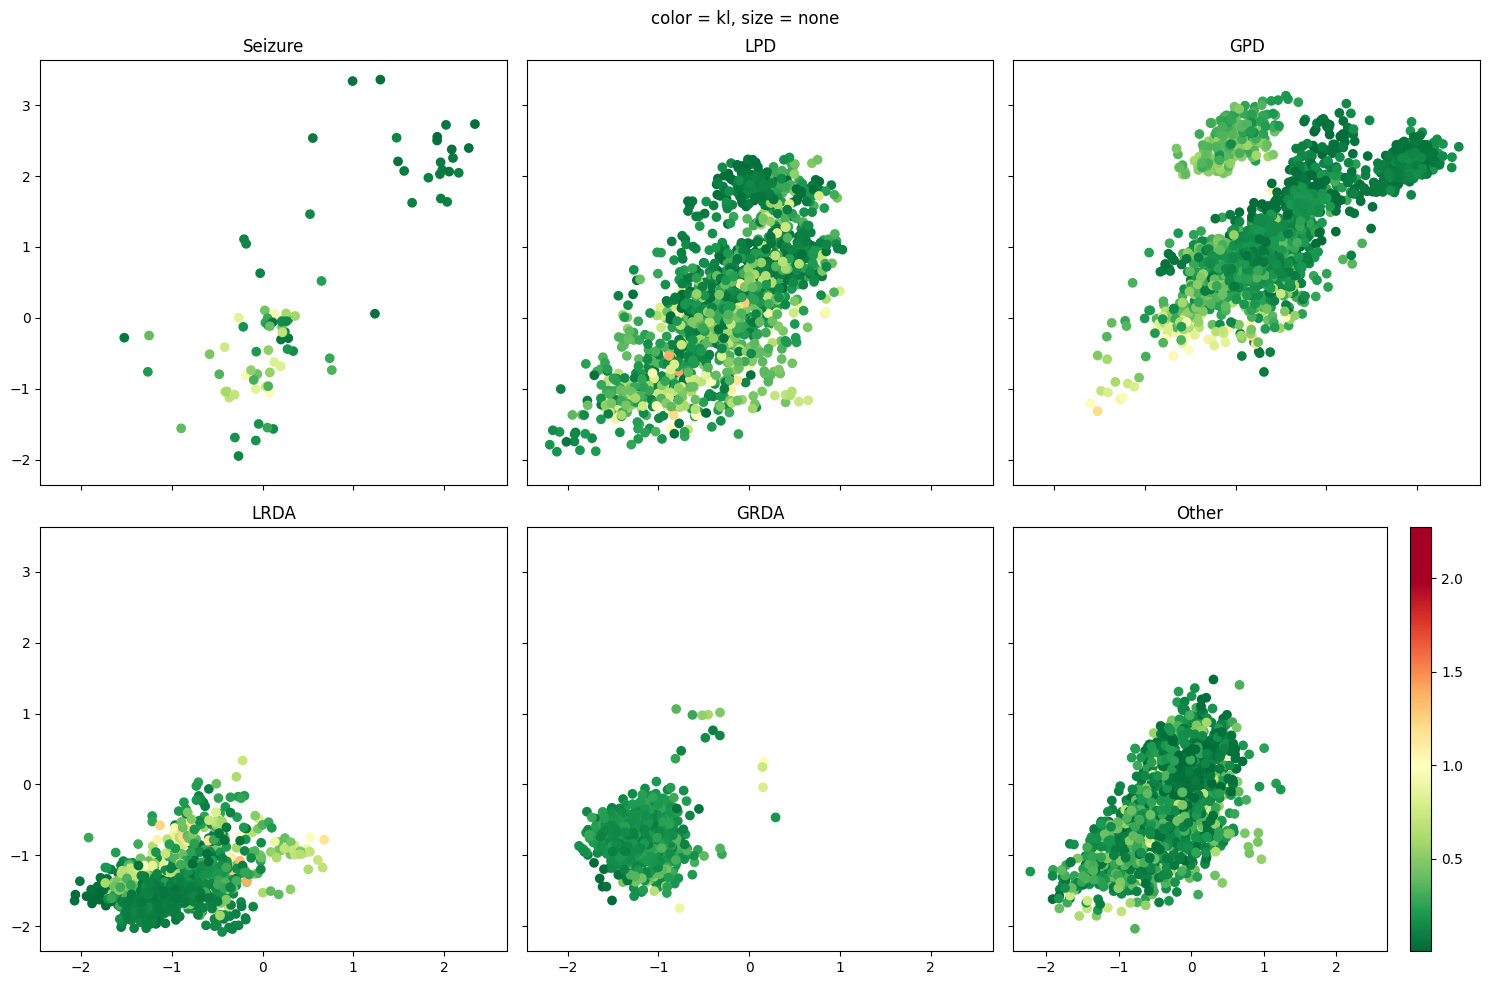

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = ((df['expert_consensus'] == ec).values) & (~df['eeg_id'].isin(bad_eeg_ids))
    df_sub = df[mask]
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_after_{split_index}.png')

In [33]:
df['eeg_id'].isin(bad_eeg_ids).sum()

187

In [34]:
df_sub = df[df['kl'] > 1.0]
bads_precise = df_sub[df_sub['eeg_id'].isin(bad_eeg_ids)][['eeg_id', 'eeg_sub_id']].values.tolist()
bad_eeg_id_sub_ids.extend(bads_precise)
len(bads_precise)

61

# Split 2

In [35]:
split_index = 2
embeddings = np.load(f'/workspace/hms/labels/predict_val/embeddings_{split_index}.npy')
logits = torch.from_numpy(np.load(f'/workspace/hms/labels/predict_val/logits_{split_index}.npy'))
df = pd.read_csv(f'/workspace/hms/labels/predict_val/meta_{split_index}.csv')

In [36]:
target = torch.from_numpy(df[LABEL_COLS_ORDERED].values)
log_preds = F.log_softmax(logits, dim=1)
df['kl'] = F.kl_div(
    log_preds, 
    target,
    log_target=False,
    reduction='none'
).sum(1).detach().numpy()

In [37]:
df['kl'].mean()

0.29515840695310713

In [38]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()


0.2483681841639733

<Axes: >

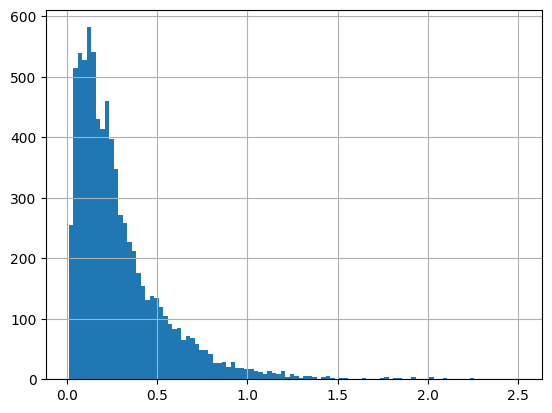

In [39]:
df['kl'].hist(bins=100)

In [40]:
reducer = umap.UMAP()
embeddings_transformed = reducer.fit_transform(embeddings)
embeddings_transformed.shape

(7968, 2)

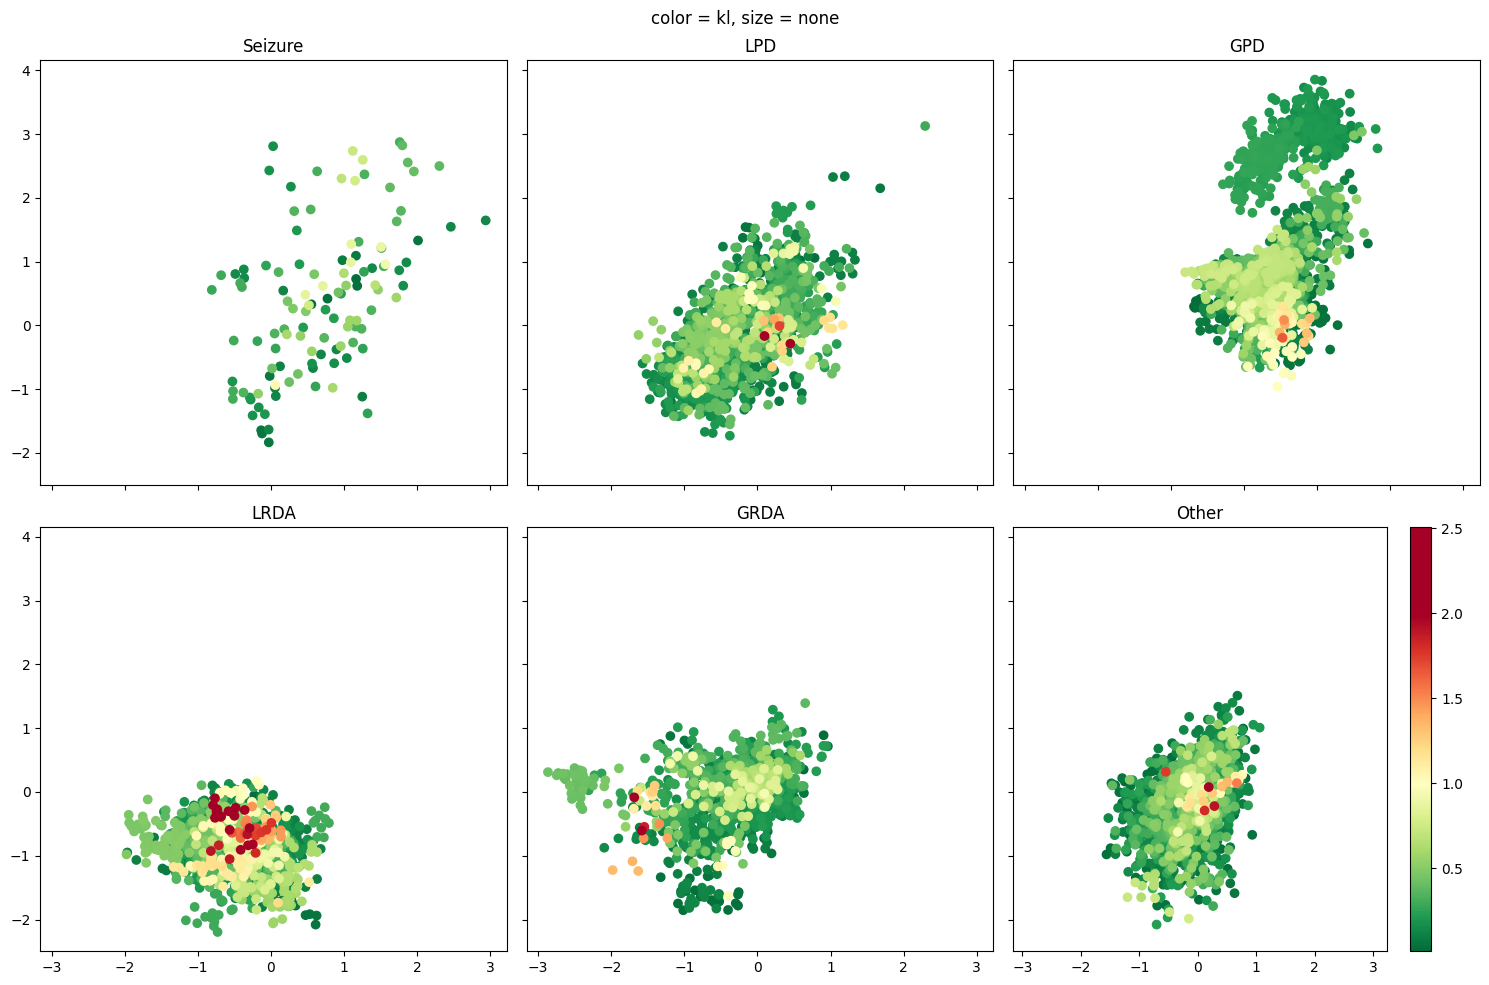

In [41]:
min_ = df['kl'].min()
max_ = df['kl'].max()
cmap = shiftedColorMap(plt.get_cmap('RdYlGn_r'), start=min_, midpoint=1.0, stop=max_, name='shifted')

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_{split_index}.png')

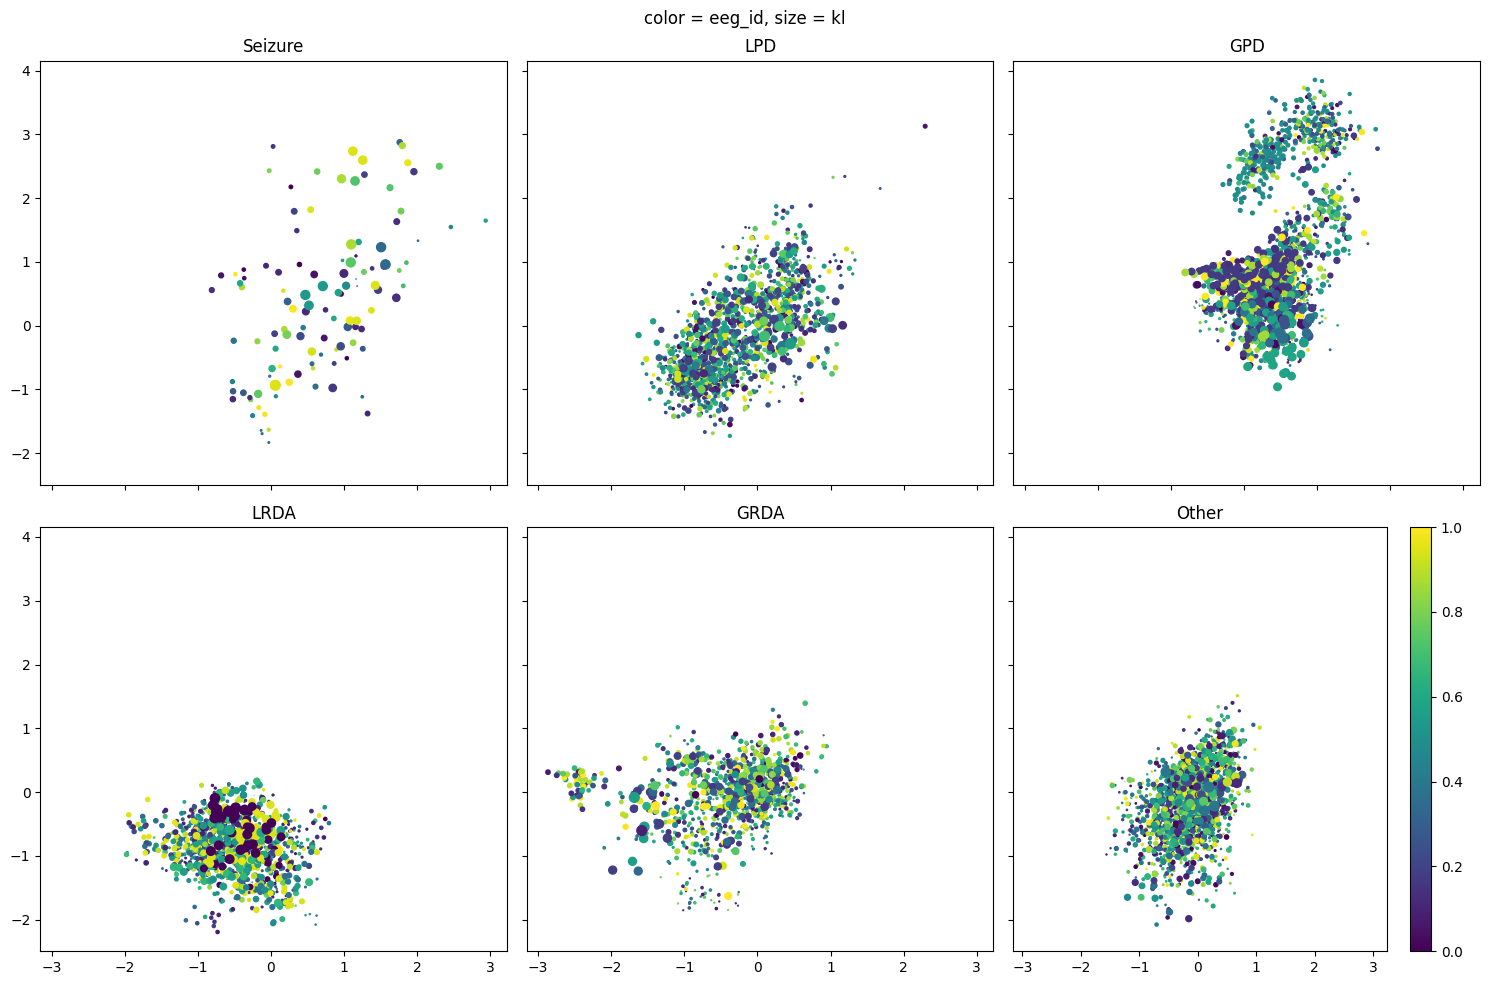

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = eeg_id, size = kl')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    # zero = 1.0
    # scale = 2 * (df_sub['kl'].max() - zero)
    # s = (
    #     df_sub['kl'] - 
    #     zero
    # ) / scale + 0.5
    s = (df_sub['kl'] - df_sub['kl'].min()) / (df_sub['kl'].max() - df_sub['kl'].min()) * 50
    # color = (df_sub['patient_id'] - df_sub['patient_id'].min()) / (df_sub['patient_id'].max() - df_sub['patient_id'].min())
    color = (df_sub['eeg_id'] - df_sub['eeg_id'].min()) / (df_sub['eeg_id'].max() - df_sub['eeg_id'].min())
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        s=s,
        c=color,
        vmin=0.0,
        vmax=1.0,
        label=ec,
        cmap='viridis'
    )
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_eeg_id_size_kl_{split_index}.png')

<Axes: >

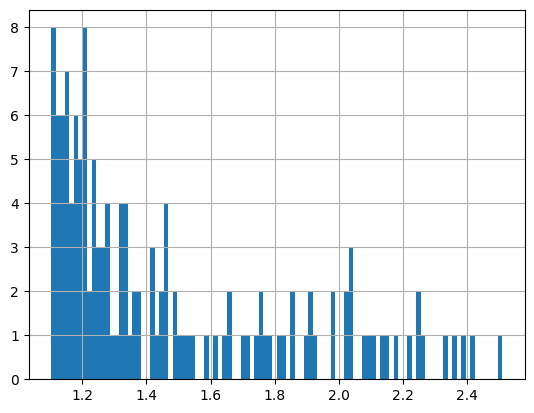

In [43]:
df[df['kl'] > 1.1]['kl'].hist(bins=100)

<Axes: >

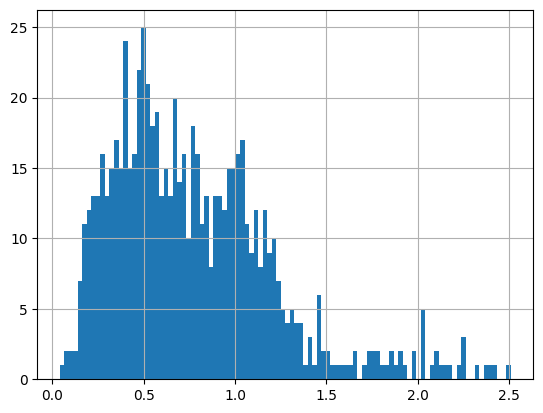

In [44]:
df[df['eeg_id'].isin(df[df['kl'] > 1.0]['eeg_id'].unique())]['kl'].hist(bins=100)

In [45]:
for ec in EXPERT_CONSENSUS_TO_LABEL_COL.keys():
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=False)
    with pd.option_context('display.max_rows', None):
        print(f'{ec}')
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id', 'eeg_sub_id', 'kl']])
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id']].value_counts())

Seizure
          eeg_id  eeg_sub_id        kl
2883  3945687482           0  1.038411
eeg_id    
3945687482    1
Name: count, dtype: int64
LPD
          eeg_id  eeg_sub_id        kl
710   2339352157           0  2.030156
4382  2953755392           3  2.019150
4381  2953755392           2  1.721233
6255   832188135          12  1.418358
5302  2251733329           0  1.315922
6919  3316372342          11  1.310624
1492  1687672273           3  1.263663
6254   832188135          11  1.246253
6252   832188135           9  1.243085
4379  2953755392           0  1.230426
1491  1687672273           2  1.216536
1493  1687672273           4  1.202656
4380  2953755392           1  1.200538
6256   832188135          13  1.166968
5765   538365115           0  1.161439
6989  1976054818           1  1.158507
711   2339352157           1  1.116076
6251   832188135           8  1.105803
6243   832188135           0  1.090563
6253   832188135          10  1.077773
6920  3316372342          12  1.074248

In [46]:
bad_eeg_ids.extend(
    [
        # Seizure
        # LPD
        2339352157,
        2953755392,
        1687672273, # ?
        2251733329,
        # GPD
        1564757889,
        1117533952,
        # LRDA
        199318654,
        4016393491, # ?
        2613466917,
        4074435757,
        # GRDA
        550607366,
        2472093870,
        936779698,
        # Other
        1686982431,
        3167808758, # ?
        2870469295,
        662870579,
        3869403939,
        484339879,
    ]
)

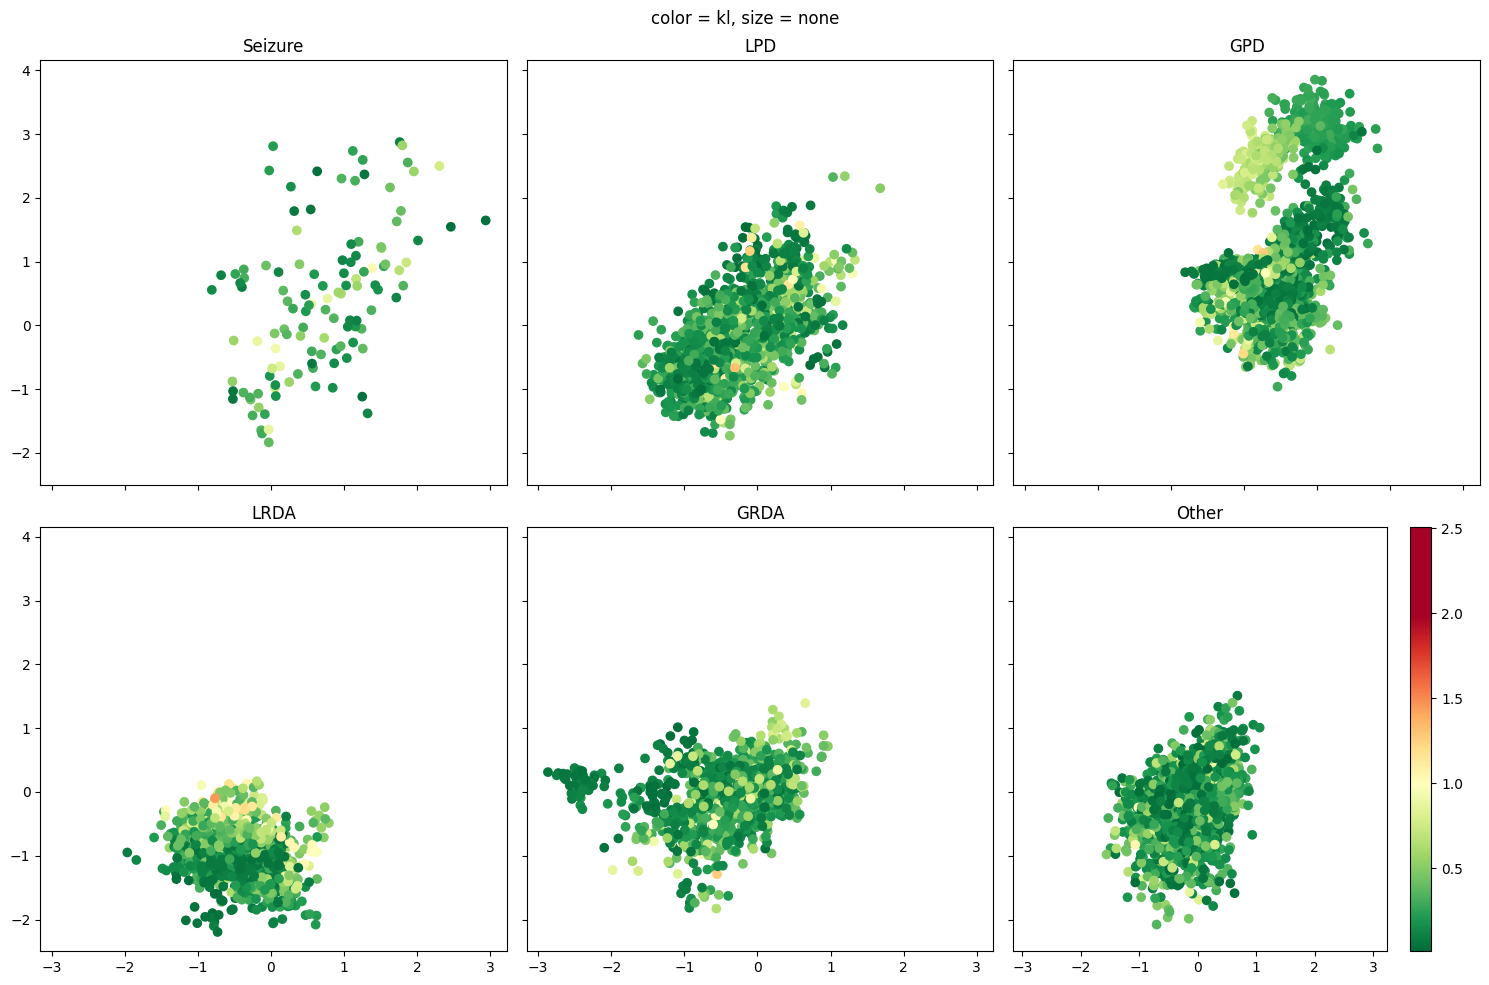

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = ((df['expert_consensus'] == ec).values) & (~df['eeg_id'].isin(bad_eeg_ids))
    df_sub = df[mask]
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_after_{split_index}.png')

In [48]:
df['eeg_id'].isin(bad_eeg_ids).sum()

247

In [49]:
df_sub = df[df['kl'] > 1.0]
bads_precise = df_sub[df_sub['eeg_id'].isin(bad_eeg_ids)][['eeg_id', 'eeg_sub_id']].values.tolist()
bad_eeg_id_sub_ids.extend(bads_precise)
len(bads_precise)

98

# Split 3

In [50]:
split_index = 3
embeddings = np.load(f'/workspace/hms/labels/predict_val/embeddings_{split_index}.npy')
logits = torch.from_numpy(np.load(f'/workspace/hms/labels/predict_val/logits_{split_index}.npy'))
df = pd.read_csv(f'/workspace/hms/labels/predict_val/meta_{split_index}.csv')

In [51]:
target = torch.from_numpy(df[LABEL_COLS_ORDERED].values)
log_preds = F.log_softmax(logits, dim=1)
df['kl'] = F.kl_div(
    log_preds, 
    target,
    log_target=False,
    reduction='none'
).sum(1).detach().numpy()

In [52]:
df['kl'].mean()

0.2564656161584224

In [53]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()


0.244240517440975

<Axes: >

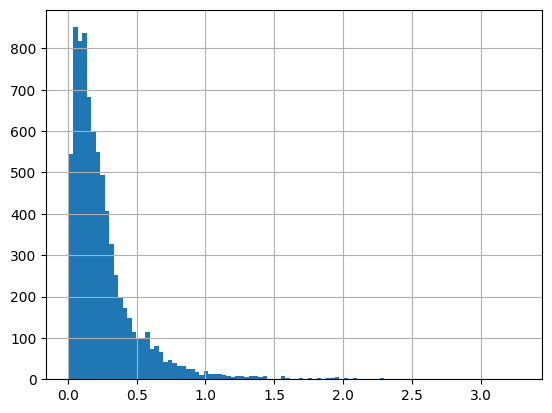

In [54]:
df['kl'].hist(bins=100)

In [55]:
reducer = umap.UMAP()
embeddings_transformed = reducer.fit_transform(embeddings)
embeddings_transformed.shape

(7968, 2)

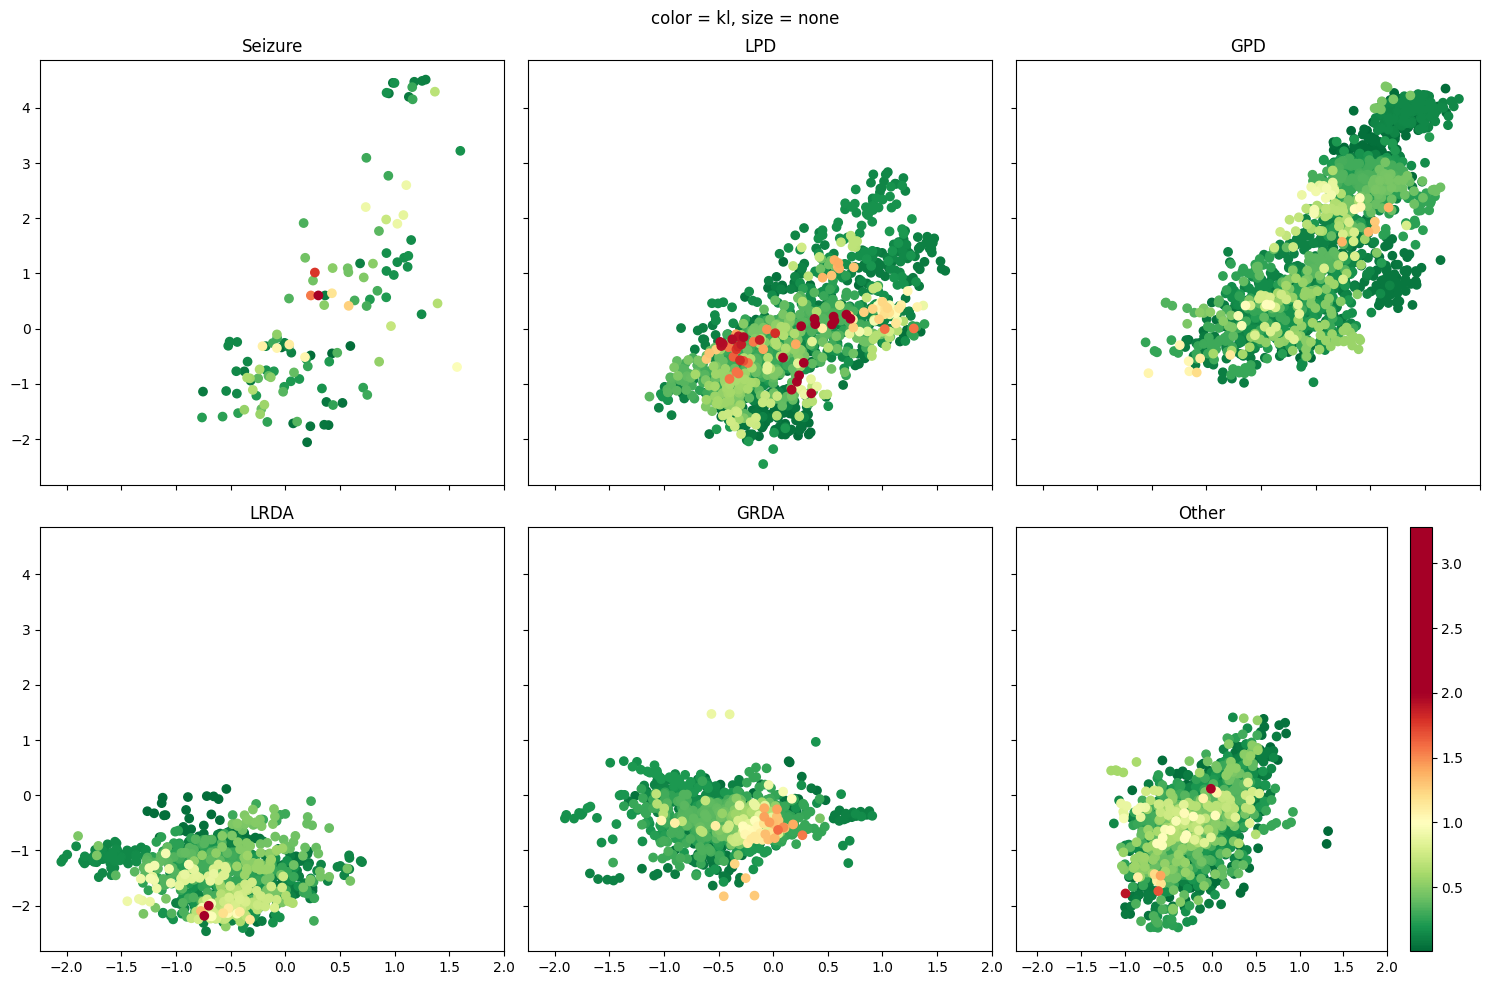

In [56]:
min_ = df['kl'].min()
max_ = df['kl'].max()
cmap = shiftedColorMap(plt.get_cmap('RdYlGn_r'), start=min_, midpoint=1.0, stop=max_, name='shifted')

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_{split_index}.png')

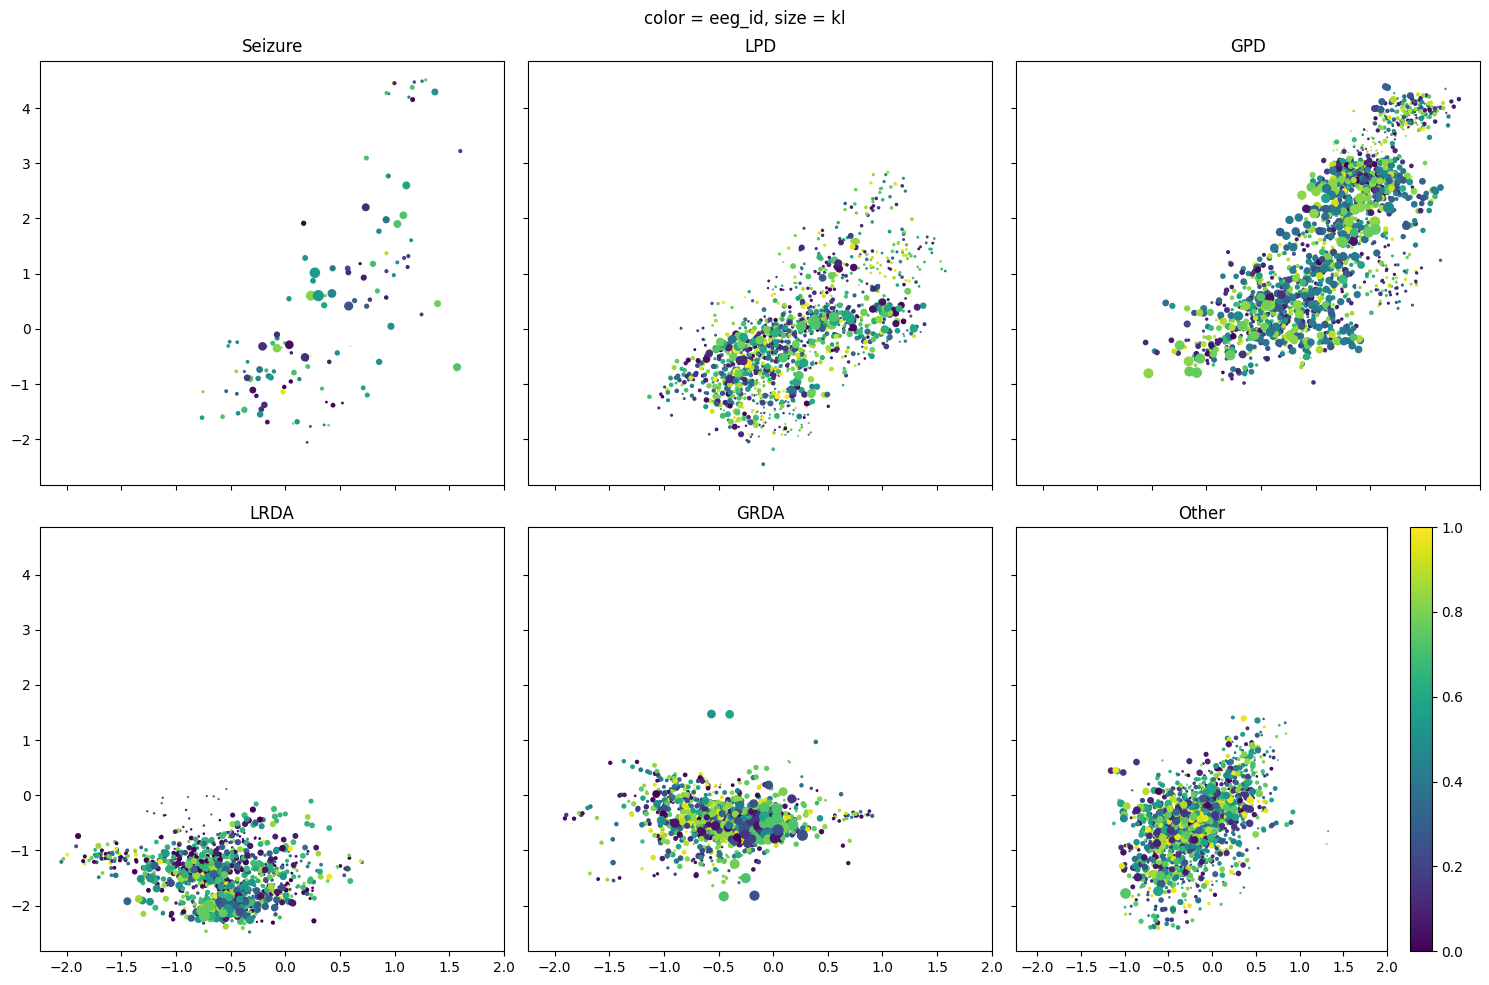

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = eeg_id, size = kl')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    # zero = 1.0
    # scale = 2 * (df_sub['kl'].max() - zero)
    # s = (
    #     df_sub['kl'] - 
    #     zero
    # ) / scale + 0.5
    s = (df_sub['kl'] - df_sub['kl'].min()) / (df_sub['kl'].max() - df_sub['kl'].min()) * 50
    # color = (df_sub['patient_id'] - df_sub['patient_id'].min()) / (df_sub['patient_id'].max() - df_sub['patient_id'].min())
    color = (df_sub['eeg_id'] - df_sub['eeg_id'].min()) / (df_sub['eeg_id'].max() - df_sub['eeg_id'].min())
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        s=s,
        c=color,
        vmin=0.0,
        vmax=1.0,
        label=ec,
        cmap='viridis'
    )
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_eeg_id_size_kl_{split_index}.png')

<Axes: >

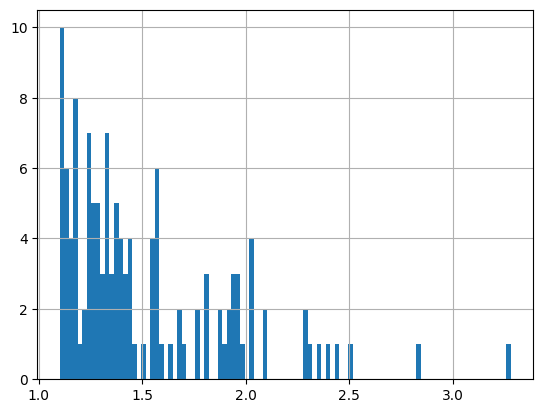

In [58]:
df[df['kl'] > 1.1]['kl'].hist(bins=100)

<Axes: >

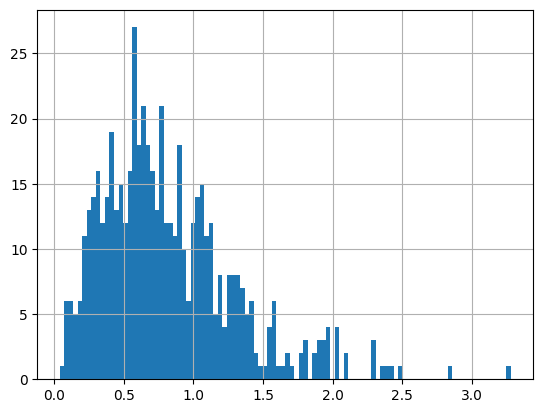

In [59]:
df[df['eeg_id'].isin(df[df['kl'] > 1.0]['eeg_id'].unique())]['kl'].hist(bins=100)

In [60]:
for ec in EXPERT_CONSENSUS_TO_LABEL_COL.keys():
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=False)
    with pd.option_context('display.max_rows', None):
        print(f'{ec}')
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id', 'eeg_sub_id', 'kl']])
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id']].value_counts())

Seizure
          eeg_id  eeg_sub_id        kl
6499  2263265660           0  2.031425
6500  2263265660           1  1.771494
3778  3411684217           4  1.548234
1230  1146981680           0  1.252002
5549  1887646005           0  1.163978
5299   148395385          10  1.112739
6527   555468987           0  1.084510
3779  3411684217           5  1.061086
6528   555468987           1  1.056634
eeg_id    
555468987     2
2263265660    2
3411684217    2
148395385     1
1146981680    1
1887646005    1
Name: count, dtype: int64
LPD
          eeg_id  eeg_sub_id        kl
5098  3077931820           6  3.280226
5097  3077931820           5  2.836667
5101  3077931820           9  2.497705
348   2521925389          27  2.437227
346   2521925389          25  2.394591
347   2521925389          26  2.361773
4152  3307048220           3  2.305793
5099  3077931820           7  2.294645
5100  3077931820           8  2.286438
339   2521925389          18  2.083920
5102  3077931820          10  2.0232

In [61]:
bad_eeg_ids.extend(
    [
        # Seizure
        2263265660,
        3411684217,
        # LPD
        3077931820,
        2521925389,
        186045431,
        3307048220,
        494494359,
        1574159360,
        3058981026,
        2704961369,
        # GPD
        1977114068,
        3344967767,
        3274420046,
        # LRDA
        3240464962,
        # GRDA
        1135870887,
        3115335233,
        3402647172,
        # Other
        2535347969,
        3154236876,
    ]
)

          eeg_id        kl
1230  1146981680  1.252002
5549  1887646005  1.163978
5299   148395385  1.112739
6527   555468987  1.084510
6528   555468987  1.056634
6156  3018383002  0.970397
486   2493996394  0.914107
6529   555468987  0.913252
6157  3018383002  0.900115
6155  3018383002  0.866938
          eeg_id        kl
72    4237848483  1.771538
71    4237848483  1.568665
70    4237848483  1.566287
2642   443208604  1.392984
564   1164359526  1.365637
2316   539328324  1.302243
6576  2343096165  1.266687
7096    81939314  1.263846
1783  3583745768  1.247579
7423  2451779997  1.225025
          eeg_id        kl
5837  3543515810  1.275450
5838  3543515810  1.057728
5839  3543515810  1.054826
5840  3543515810  1.046834
5833  3543515810  1.020918
4312  1763059830  1.017127
5818  3543515810  1.012005
5832  3543515810  0.994712
5831  3543515810  0.991963
5830  3543515810  0.945008
          eeg_id        kl
716   2221330234  1.148606
4469  1011074181  1.127231
717   2221330234  1.124495
7

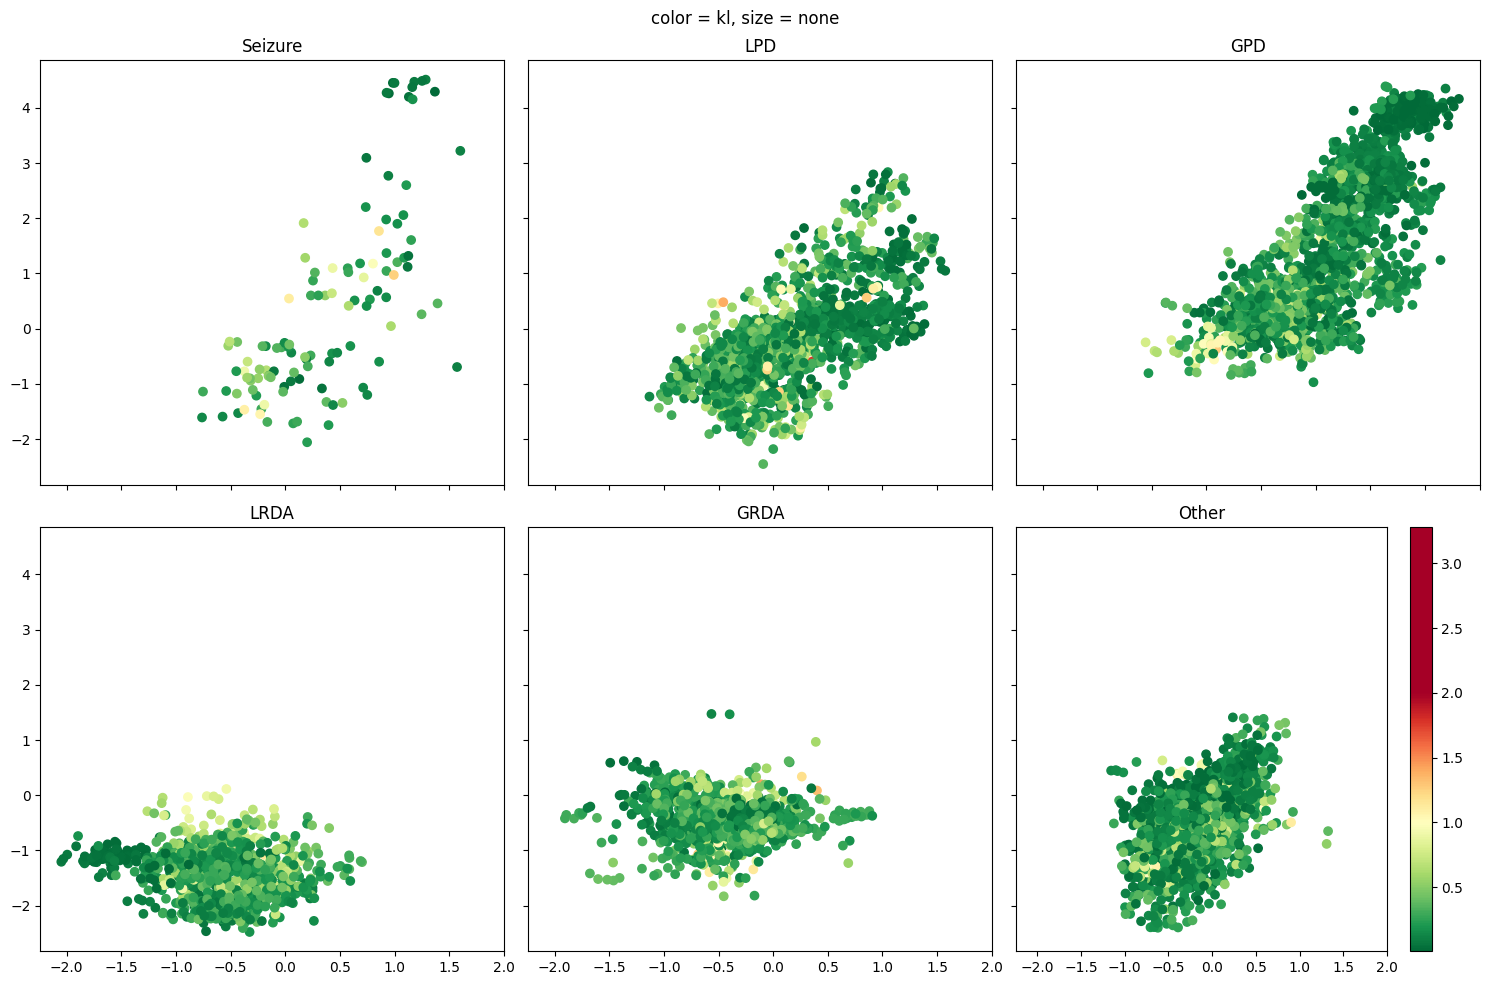

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = ((df['expert_consensus'] == ec).values) & (~df['eeg_id'].isin(bad_eeg_ids))
    df_sub = df[mask]
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    print(df_sub.sort_values('kl', ascending=False).head(10)[['eeg_id', 'kl']])
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_after_{split_index}.png')

In [63]:
df['eeg_id'].isin(bad_eeg_ids).sum()

175

In [64]:
df_sub = df[df['kl'] > 1.0]
bads_precise = df_sub[df_sub['eeg_id'].isin(bad_eeg_ids)][['eeg_id', 'eeg_sub_id']].values.tolist()
bad_eeg_id_sub_ids.extend(bads_precise)
len(bads_precise)

102

# Split 4

In [65]:
split_index = 4
embeddings = np.load(f'/workspace/hms/labels/predict_val/embeddings_{split_index}.npy')
logits = torch.from_numpy(np.load(f'/workspace/hms/labels/predict_val/logits_{split_index}.npy'))
df = pd.read_csv(f'/workspace/hms/labels/predict_val/meta_{split_index}.csv')

In [66]:
target = torch.from_numpy(df[LABEL_COLS_ORDERED].values)
log_preds = F.log_softmax(logits, dim=1)
df['kl'] = F.kl_div(
    log_preds, 
    target,
    log_target=False,
    reduction='none'
).sum(1).detach().numpy()

In [67]:
df['kl'].mean()

0.2684382539574699

In [68]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()


0.22758311755421562

<Axes: >

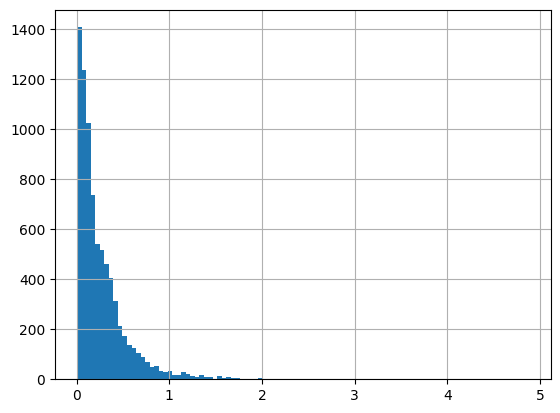

In [69]:
df['kl'].hist(bins=100)

In [70]:
reducer = umap.UMAP()
embeddings_transformed = reducer.fit_transform(embeddings)
embeddings_transformed.shape

(7968, 2)

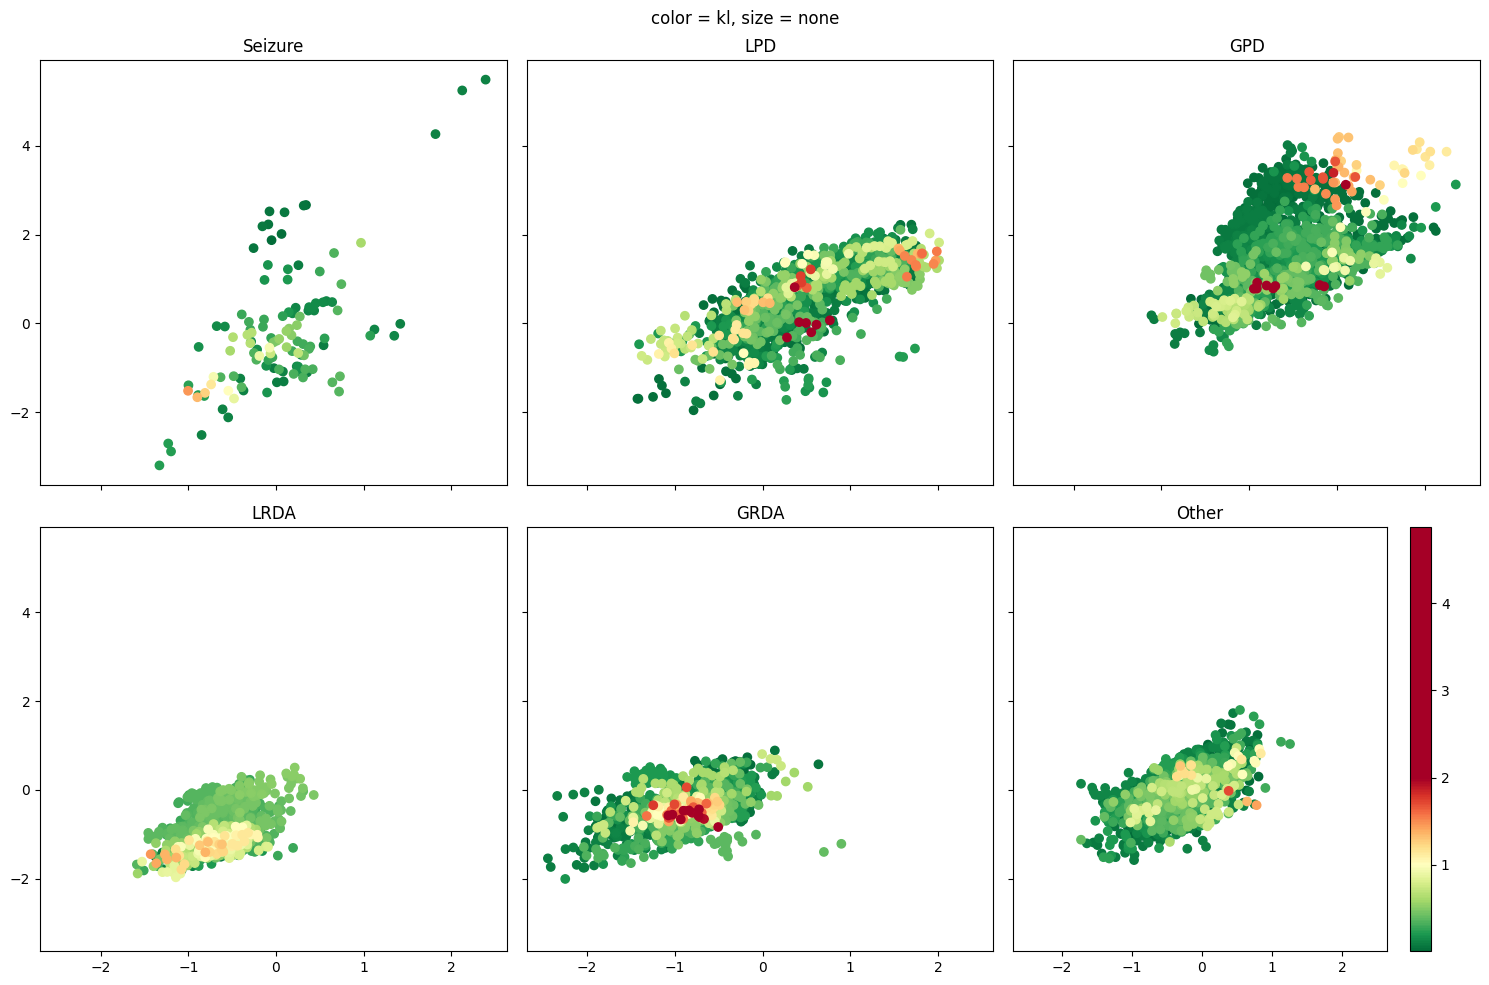

In [71]:
min_ = df['kl'].min()
max_ = df['kl'].max()
cmap = shiftedColorMap(plt.get_cmap('RdYlGn_r'), start=min_, midpoint=1.0, stop=max_, name='shifted')

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_{split_index}.png')

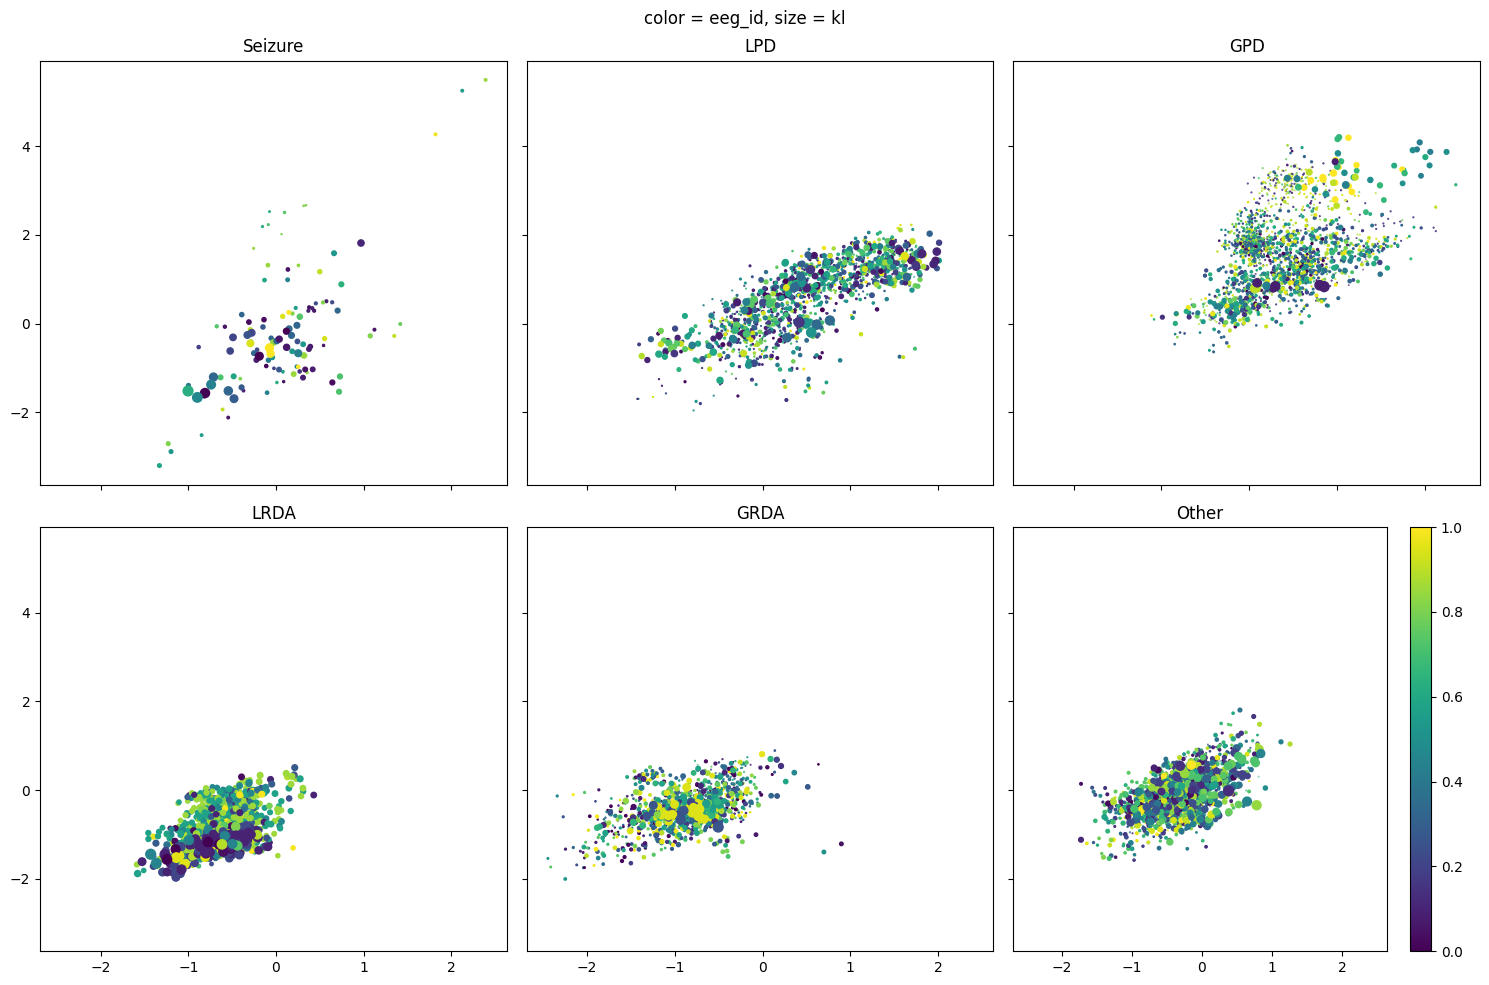

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = eeg_id, size = kl')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=True)
    # zero = 1.0
    # scale = 2 * (df_sub['kl'].max() - zero)
    # s = (
    #     df_sub['kl'] - 
    #     zero
    # ) / scale + 0.5
    s = (df_sub['kl'] - df_sub['kl'].min()) / (df_sub['kl'].max() - df_sub['kl'].min()) * 50
    # color = (df_sub['patient_id'] - df_sub['patient_id'].min()) / (df_sub['patient_id'].max() - df_sub['patient_id'].min())
    color = (df_sub['eeg_id'] - df_sub['eeg_id'].min()) / (df_sub['eeg_id'].max() - df_sub['eeg_id'].min())
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        s=s,
        c=color,
        vmin=0.0,
        vmax=1.0,
        label=ec,
        cmap='viridis'
    )
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_eeg_id_size_kl_{split_index}.png')

<Axes: >

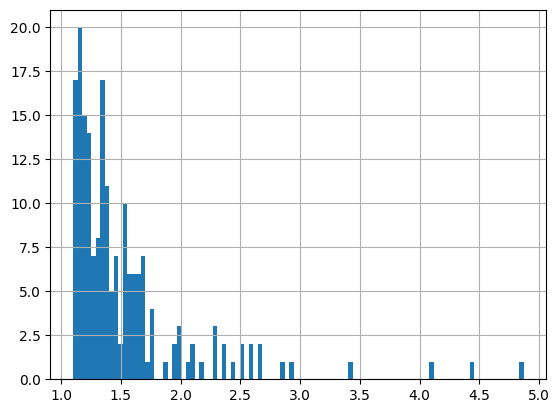

In [73]:
df[df['kl'] > 1.1]['kl'].hist(bins=100)

<Axes: >

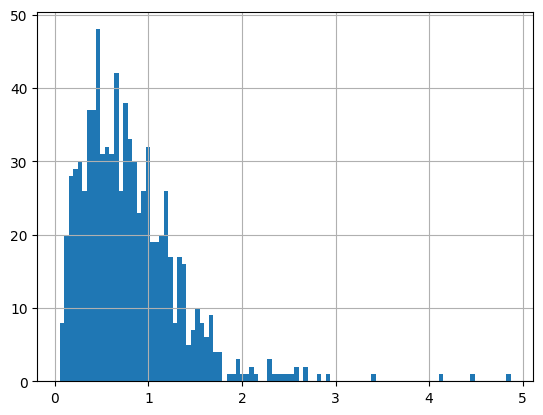

In [74]:
df[df['eeg_id'].isin(df[df['kl'] > 1.0]['eeg_id'].unique())]['kl'].hist(bins=100)

In [75]:
for ec in EXPERT_CONSENSUS_TO_LABEL_COL.keys():
    mask = (df['expert_consensus'] == ec).values
    df_sub = df[mask]
    df_sub = df_sub.sort_values('kl', ascending=False)
    with pd.option_context('display.max_rows', None):
        print(f'{ec}')
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id', 'eeg_sub_id', 'kl']])
        print(df_sub[df_sub['kl'] > 1.0][['eeg_id']].value_counts())

Seizure
          eeg_id  eeg_sub_id        kl
5484  2639737493           0  1.456694
2780  1993146425           0  1.354434
2299    71524527           1  1.245041
5014  1870063896           4  1.131694
1731  1407508671           1  1.005729
eeg_id    
71524527      1
1407508671    1
1870063896    1
1993146425    1
2639737493    1
Name: count, dtype: int64
LPD
          eeg_id  eeg_sub_id        kl
5668   676375482           2  2.847803
6732  2205765930           1  2.667589
6731  2205765930           0  2.585549
5703  1473973712           0  2.376499
5705  1473973712           2  2.353722
5707  1473973712           4  2.071909
5704  1473973712           1  1.977607
5669   676375482           3  1.759764
5708  1473973712           5  1.753014
6733  2205765930           2  1.747934
2159   464456152           0  1.633069
7861   967434882           0  1.624971
2161   464456152           2  1.589105
2162   464456152           3  1.560261
5706  1473973712           3  1.549515
5670   676375

In [89]:
bad_eeg_ids.extend(
    [
        # Seizure
        2639737493,
        1993146425,
        71524527,
        # LPD
        676375482,
        2205765930,
        1473973712,
        464456152,
        4071144306,
        332028985,
        967434882,
        # 3019570857
        # GPD
        376815266,
        1818516802,
        3830168237,
        4244523369,
        1818516802,
        2838445048,
        2150180109,
        2084690855,
        # LRDA
        1871865290,
        46540529,
        # GRDA
        1176006128,
        4070155528,
        967686067,
        2422221889,
        2414022501,
        # Other
        542248976,
        3607088659,
    ]
)

          eeg_id        kl
5014  1870063896  1.131694
1731  1407508671  1.005729
1730  1407508671  0.952883
5603  4169534663  0.941195
2713  1257934459  0.879874
5602  4169534663  0.737921
7478  1818278493  0.700139
6863  3935833947  0.668187
2237  1119181122  0.659714
4298   928042128  0.657536
          eeg_id        kl
1228  1846327272  1.353254
5347  3019570857  1.342349
1230  1846327272  1.302653
1229  1846327272  1.257038
4585  3188013590  1.224130
4588  3188013590  1.222276
5608   372174920  1.207869
4587  3188013590  1.197219
5433  2574926654  1.178175
1231  1846327272  1.168094
          eeg_id        kl
5052  2616030382  1.334938
5049  2616030382  1.153746
5062  2616030382  1.068050
5054  2616030382  1.007814
5063  2616030382  0.930368
7056  1615245074  0.920155
5073  2616030382  0.886225
5064  2616030382  0.874468
7785  2501470710  0.871136
5050  2616030382  0.868244
          eeg_id        kl
4750   423123150  1.373441
6823  3935455658  1.362532
4748   423123150  1.361320
1

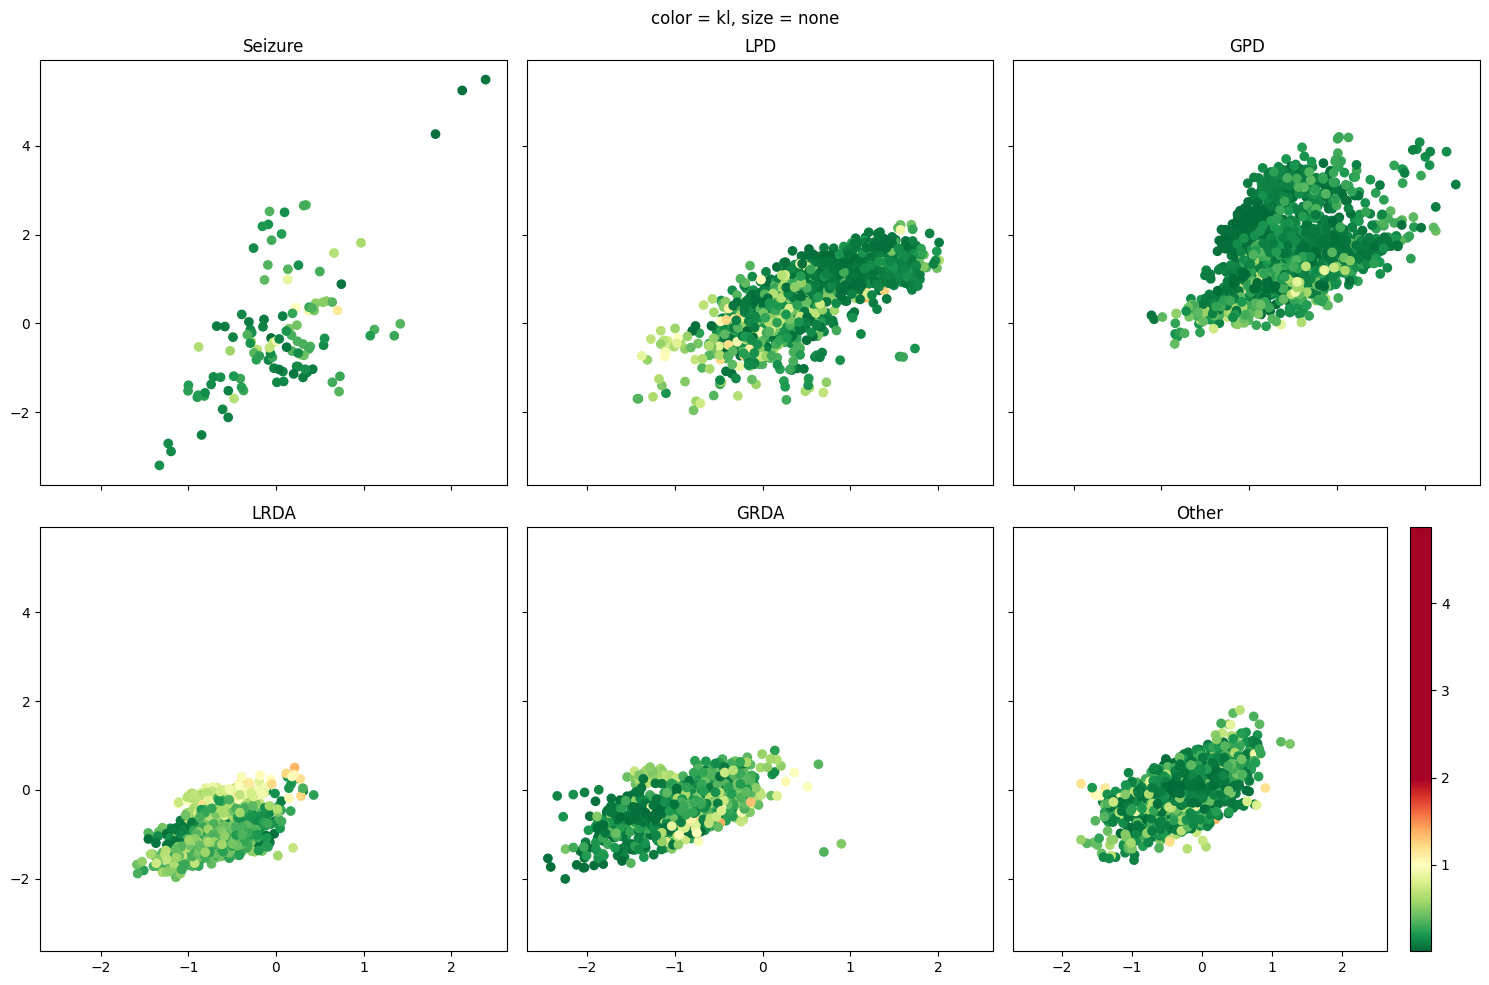

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('color = kl, size = none')
for i, (ec, ax) in enumerate(zip(EXPERT_CONSENSUS_TO_LABEL_COL.keys(), axes.flatten())):
    mask = ((df['expert_consensus'] == ec).values) & (~df['eeg_id'].isin(bad_eeg_ids))
    df_sub = df[mask]
    ax.set_title(f'{ec}')
    sc = ax.scatter(
        embeddings[mask, 0], 
        embeddings[mask, 1], 
        c=df_sub['kl'].values,
        vmin=min_,
        vmax=max_,
        label=ec,
        cmap=cmap,
    )
    print(df_sub.sort_values('kl', ascending=False).head(10)[['eeg_id', 'kl']])
    
    if i == 5:
        fig.colorbar(sc, ax=ax)
fig.tight_layout()
fig.savefig(f'/workspace/hms/labels/predict_val/color_kl_size_none_after_{split_index}.png')

In [91]:
df['eeg_id'].isin(bad_eeg_ids).sum()

360

In [92]:
df_sub = df[df['kl'] > 1.0]
bads_precise = df_sub[df_sub['eeg_id'].isin(bad_eeg_ids)][['eeg_id', 'eeg_sub_id']].values.tolist()
bad_eeg_id_sub_ids.extend(bads_precise)
len(bads_precise)

155

In [95]:
bad_eeg_id_sub_ids

[[3120659896, 0],
 [3120659896, 1],
 [3120659896, 2],
 [3120659896, 3],
 [3120659896, 4],
 [3120659896, 5],
 [3120659896, 8],
 [3120659896, 9],
 [3120659896, 11],
 [1591129178, 0],
 [1591129178, 3],
 [3395696113, 10],
 [3395696113, 11],
 [3395696113, 12],
 [3395696113, 13],
 [3395696113, 14],
 [3395696113, 15],
 [3395696113, 16],
 [3395696113, 17],
 [3395696113, 18],
 [660412648, 0],
 [660412648, 1],
 [4087242707, 4],
 [4087242707, 5],
 [4087242707, 6],
 [4087242707, 7],
 [4087242707, 8],
 [2055552797, 0],
 [2055552797, 1],
 [2055552797, 2],
 [2055552797, 3],
 [2055552797, 4],
 [2055552797, 5],
 [2055552797, 6],
 [2055552797, 8],
 [2055552797, 9],
 [2055552797, 10],
 [2055552797, 11],
 [2055552797, 12],
 [2055552797, 13],
 [4073859883, 0],
 [4073859883, 1],
 [4073859883, 2],
 [3149658468, 0],
 [3149658468, 5],
 [3149658468, 6],
 [3149658468, 11],
 [3149658468, 12],
 [2713014975, 0],
 [2713014975, 1],
 [2713014975, 2],
 [2713014975, 3],
 [2713014975, 4],
 [2713014975, 5],
 [2713014975, 

In [96]:
[tuple(x) for x in bad_eeg_id_sub_ids]

[(3120659896, 0),
 (3120659896, 1),
 (3120659896, 2),
 (3120659896, 3),
 (3120659896, 4),
 (3120659896, 5),
 (3120659896, 8),
 (3120659896, 9),
 (3120659896, 11),
 (1591129178, 0),
 (1591129178, 3),
 (3395696113, 10),
 (3395696113, 11),
 (3395696113, 12),
 (3395696113, 13),
 (3395696113, 14),
 (3395696113, 15),
 (3395696113, 16),
 (3395696113, 17),
 (3395696113, 18),
 (660412648, 0),
 (660412648, 1),
 (4087242707, 4),
 (4087242707, 5),
 (4087242707, 6),
 (4087242707, 7),
 (4087242707, 8),
 (2055552797, 0),
 (2055552797, 1),
 (2055552797, 2),
 (2055552797, 3),
 (2055552797, 4),
 (2055552797, 5),
 (2055552797, 6),
 (2055552797, 8),
 (2055552797, 9),
 (2055552797, 10),
 (2055552797, 11),
 (2055552797, 12),
 (2055552797, 13),
 (4073859883, 0),
 (4073859883, 1),
 (4073859883, 2),
 (3149658468, 0),
 (3149658468, 5),
 (3149658468, 6),
 (3149658468, 11),
 (3149658468, 12),
 (2713014975, 0),
 (2713014975, 1),
 (2713014975, 2),
 (2713014975, 3),
 (2713014975, 4),
 (2713014975, 5),
 (2713014975, 

In [98]:
bad_eeg_ids

[4087242707,
 2328924181,
 3161513637,
 3120659896,
 3395696113,
 660412648,
 2096583018,
 4134620961,
 1386986988,
 4073859883,
 2131102397,
 3149658468,
 2713014975,
 3475982496,
 3760885021,
 3216469722,
 4084957171,
 9240926,
 2055552797,
 701025595,
 3468817078,
 2313862496,
 1591129178,
 3500954630,
 3960652136,
 3125082527,
 1726717743,
 2992127004,
 2368162206,
 981282155,
 2180165624,
 759620270,
 1735972851,
 3450996114,
 235218950,
 1542745222,
 3232757274,
 2339352157,
 2953755392,
 1687672273,
 2251733329,
 1564757889,
 1117533952,
 199318654,
 4016393491,
 2613466917,
 4074435757,
 550607366,
 2472093870,
 936779698,
 1686982431,
 3167808758,
 2870469295,
 662870579,
 3869403939,
 484339879,
 2263265660,
 3411684217,
 3077931820,
 2521925389,
 186045431,
 3307048220,
 494494359,
 1574159360,
 3058981026,
 2704961369,
 1977114068,
 3344967767,
 3274420046,
 3240464962,
 1135870887,
 3115335233,
 3402647172,
 2535347969,
 3154236876,
 2639737493,
 1993146425,
 71524527,
 67

In [102]:
df.sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()

0.22758311755421562

In [103]:
df[~df['eeg_id'].isin(bad_eeg_ids)].sort_values(['eeg_id', 'eeg_sub_id']).groupby('eeg_id').apply(lambda x: x.iloc[len(x) // 2], include_groups=False).reset_index(drop=False)['kl'].mean()

0.20769061018604457